# Introduction

This is the analysis of gut intestinal stem cell data as presented in Böttcher et al. We use in total **75,012** cells from **14 samples** in **6 conditions** (2 replicates in each mutant, 3 replicates in each control and 1 sample FVR only controls):

* Control (whole crypt)
* Control (FVR enriched)
* Control (FVR only)
* Mutant (Fltp deficient, whole crypt)
* Mutant (Fltp deficient, FVR enriched)
* Control (High fat diet project)

In this notebook, data are batch corrected and normalised.

We filtered cells by

* number of reads
* number of detected genes
* fraction of mitochondrial reads (< 10%) 


## Tasks in this notebook

In order to keep the notebook structure short and well-arranged, we have split the gut intestinal stem cell analysis into several parts:

1. Pre-processing and filtering
2. Preparation of Batch effect correction
3. Batch effect correction with adjusted Combat
4. Cell type annotation (control only) 
    * ISC subtype annotation
    * Goblet, Paneth, Tuft cell subtype annotation
    * EEC subtype annotation
5. Data analysis with Graph abstraction (control only)
6. Pseudotime analysis of ISC-PC-EEC-Goblet lineage

This notebook covers **part 4** with EEC subtype annotation.

# Initialise scanpy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.colors as colors
import scanpy.api as sc
import matplotlib as mpl
import anndata
#import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import scipy as sci
import os

sc.settings.verbosity = 3                # amount of output
sc.settings.set_figure_params(dpi=60, color_map='RdYlBu_r')
sc.logging.print_version_and_date()

Running Scanpy 1.3.1 on 2021-02-07 23:01.


In [2]:
import datetime

now = datetime.datetime.now()

In [3]:
today = now.strftime("%y%m%d")

Add custom color map.

In [4]:
colors2 = pl.cm.RdGy_r(np.linspace(0.4, 1, 128))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colors2)

## Load extensions

In [30]:
%run '~/Documents/Python/maren_codes/bar_frequency.py'
%run '~/Documents/Python/maren_codes/cal_density.py'
%run '~/Documents/Python/maren_codes/genes_to_xls.py'

# Load data

Load the data set with all cells and all genes that is batch effect corrected with `ComBat` and the zero-fix. In addition, we have normalised by library size the data after batch correction. The corrected file is coupled with the full raw data (as `raw`, non-mutant cells).

We started annotating the data in the previous notebooks. When we annotated the Tuft cells, we excluded some putative doublet cells.

In [5]:
adata_ctrl= sc.read('./../data/gut_AB_AL_log_cor_control_anno.h5ad')

In [6]:
pd.value_counts(adata_ctrl.obs['sample'])

Control_5_FVR         8849
Control_7_FVR_only    8511
Control_6             7052
CD_2                  5227
CD_1                  5213
Control_4_FVR         5068
CD_3                  4983
Control_3_FVR         4381
Control_1             3826
Control_2             3130
Name: sample, dtype: int64

# Cell type annotation and refinement

## Resolve EEC cluster

In [7]:
eec_idx = np.in1d(adata_ctrl.obs['refined_clustering'],'EEC')
a_EEC = adata_ctrl[eec_idx,:]

In [8]:
sc.tl.pca(a_EEC, svd_solver='arpack')

In [9]:
sc.tl.tsne(a_EEC)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:16.88) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [10]:
sc.pp.neighbors(a_EEC)
sc.tl.umap(a_EEC, min_dist=0.09)

computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/Maren.Buettner/miniconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:04.38) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:05.28) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [11]:
sc.tl.louvain(a_EEC, resolution=0.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.17) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


    number of colors in `.uns[louvain'_colors']` smaller than number of categories, falling back to palette


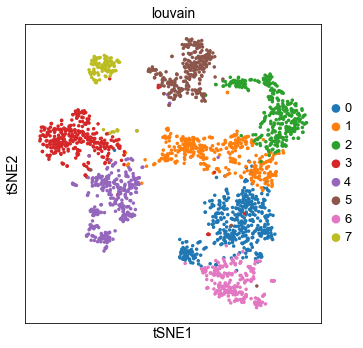

In [12]:
rcParams['figure.figsize']=(5,5)
sc.pl.tsne(a_EEC, color='louvain')

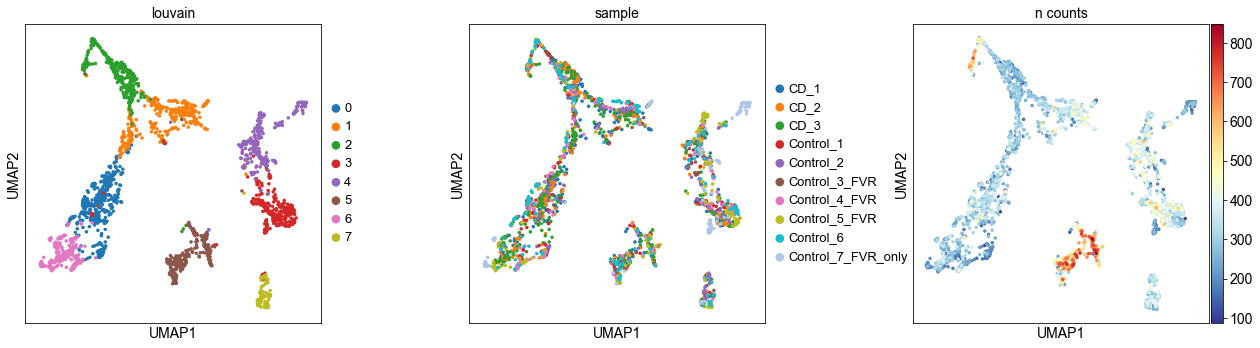

In [13]:
sc.pl.umap(a_EEC, color=[ 'louvain','sample', 'n_counts'])

In [14]:
sc.tl.rank_genes_groups(a_EEC, groupby='louvain')

ranking genes
    finished (0:00:01.97) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids


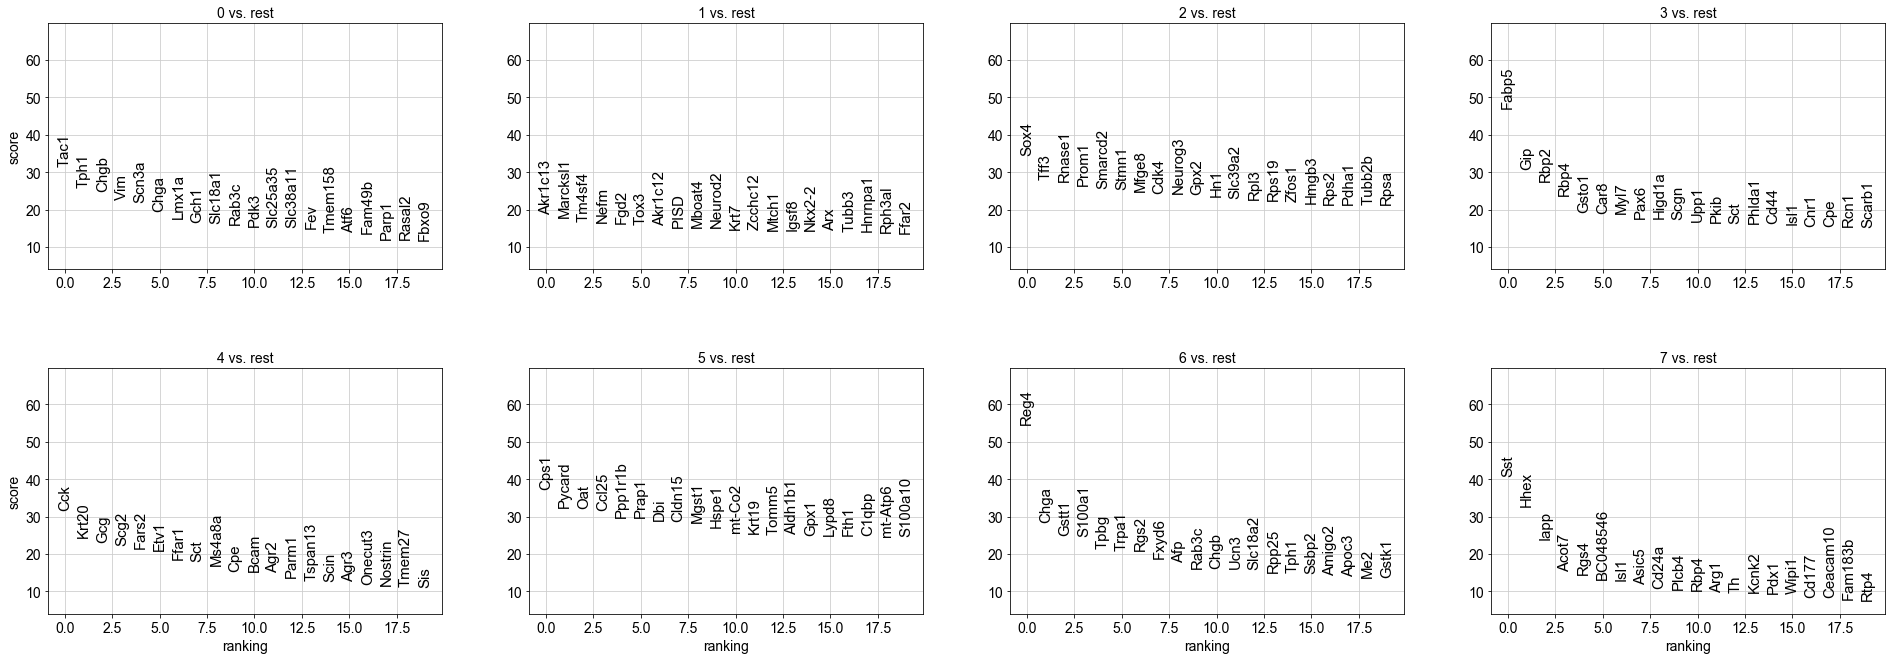

In [15]:
rcParams['figure.figsize']=(8,5)
sc.pl.rank_genes_groups(a_EEC, fontsize=15)

### Visualise marker genes

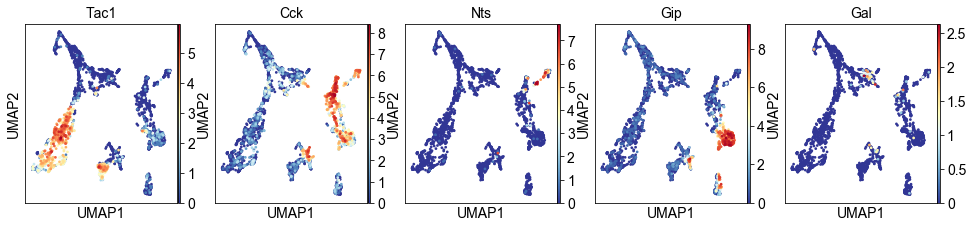

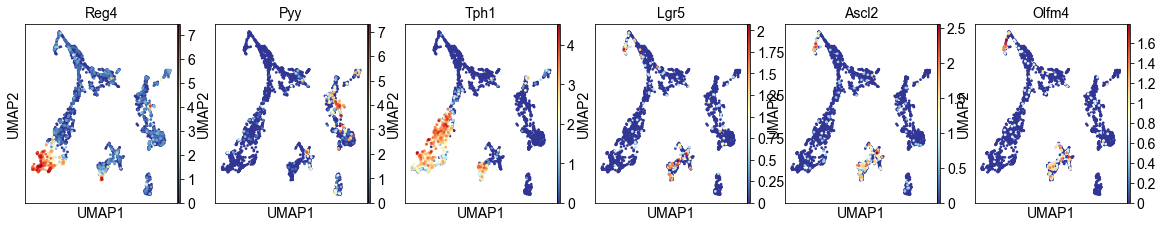

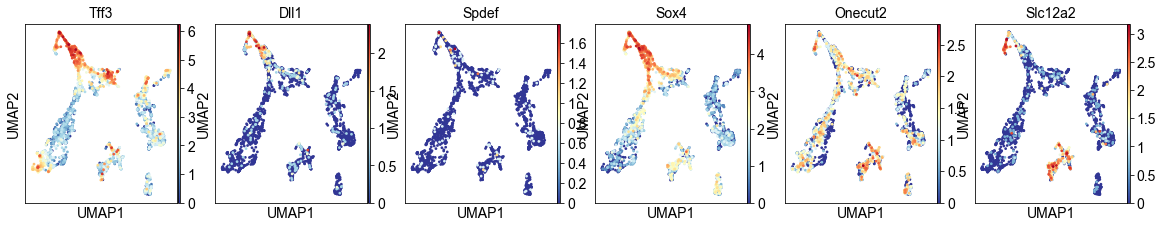

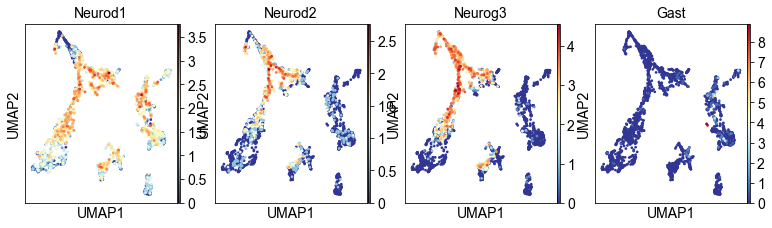

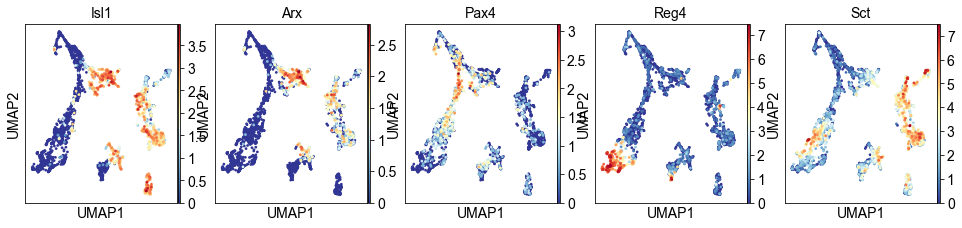

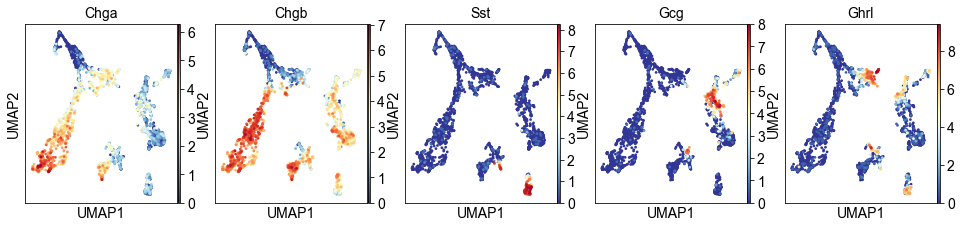

In [16]:
rcParams['figure.figsize']=(3,3)
sc.pl.umap(a_EEC, color=['Tac1', 'Cck', 'Nts', 'Gip', 'Gal'], size=30)
sc.pl.umap(a_EEC, color=['Reg4', 'Pyy', 'Tph1', 'Lgr5', 'Ascl2', 'Olfm4'], size=30)
sc.pl.umap(a_EEC, color=['Tff3', 'Dll1', 'Spdef', 'Sox4', 'Onecut2', 'Slc12a2'], size=30)
sc.pl.umap(a_EEC, color=['Neurod1','Neurod2', 'Neurog3', 'Gast'], size=30)
sc.pl.umap(a_EEC, color=['Isl1', 'Arx', 'Pax4', 'Reg4','Sct'], size=30)
sc.pl.umap(a_EEC, color=[ 'Chga', 'Chgb', 'Sst', 'Gcg', 'Ghrl'], size=30)


### Refine cluster 0 and 1 (EC, Pax4-pro and Ghrl positive cells)

In [17]:
sc.tl.louvain(a_EEC, resolution=2, restrict_to=['louvain',['0', '1']])

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.03) --> found 13 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical)


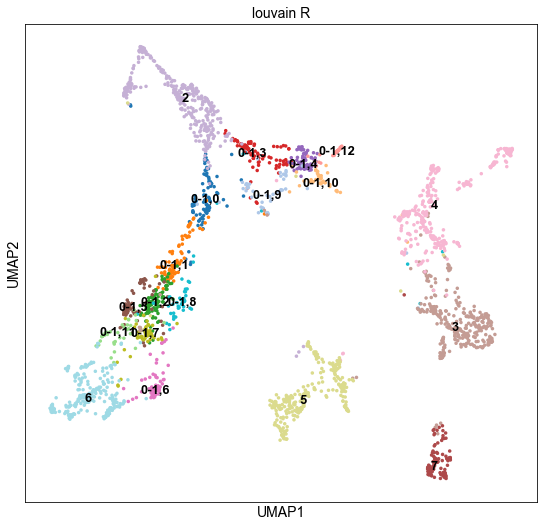

In [18]:
rcParams['figure.figsize']=(8,8)
sc.pl.umap(a_EEC, color='louvain_R', legend_loc='on data')

### Refine cluster 2 (early Neurog3 positive cells)

In [19]:
sc.tl.louvain(a_EEC,  resolution=0.5, restrict_to=['louvain_R',['2']])

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.02) --> found 4 clusters and added
    'louvain_R_R', the cluster labels (adata.obs, categorical)


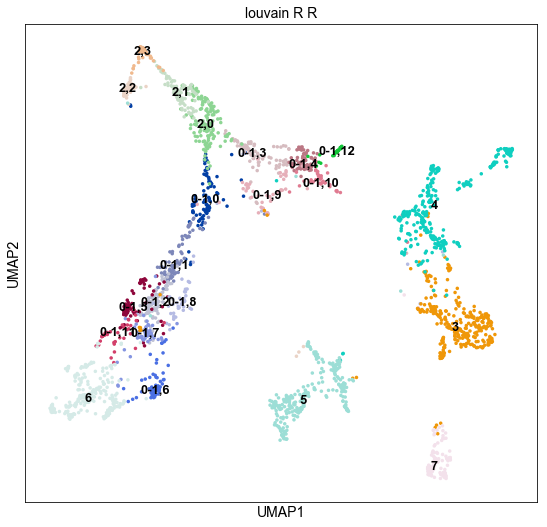

In [20]:
sc.pl.umap(a_EEC, color='louvain_R_R', legend_loc='on data')

### Refine cluster 3 (Gip positive)

In [21]:
sc.tl.louvain(a_EEC, resolution=0.5, restrict_to=['louvain_R_R',['3']])


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.02) --> found 4 clusters and added
    'louvain_R_R_R', the cluster labels (adata.obs, categorical)


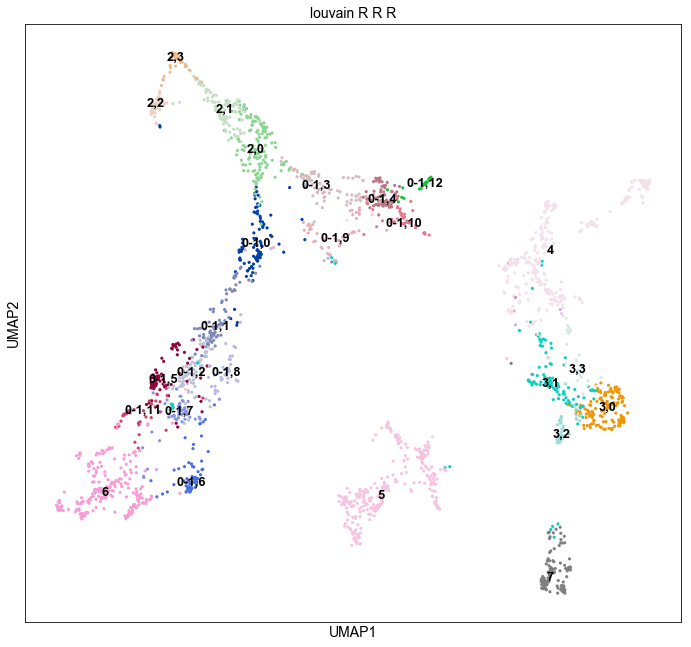

In [22]:
rcParams['figure.figsize']=(10,10)
sc.pl.umap(a_EEC, color='louvain_R_R_R', size=40, legend_loc='on data')

### Refine cluster 4 (Hormone positive cells)

In [46]:
sc.tl.louvain(a_EEC, resolution=1, restrict_to=['louvain_R_R_R',['4']])

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 6 clusters and added
    'louvain_R_R_R_R', the cluster labels (adata.obs, categorical)


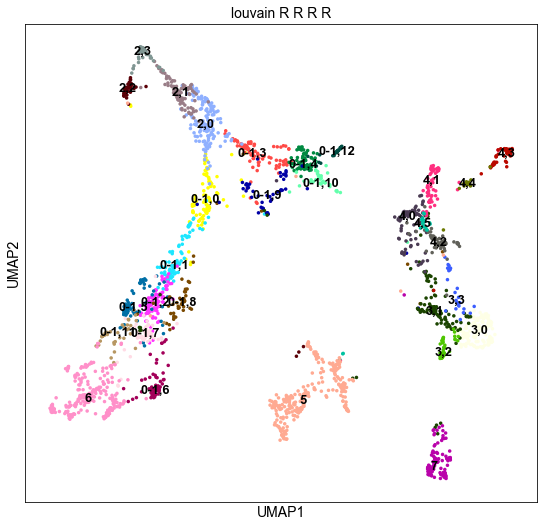

In [49]:
rcParams['figure.figsize']=(8,8)
sc.pl.umap(a_EEC, color='louvain_R_R_R_R', legend_loc='on data')

### Refine cluster 5 (Lgr5 positive cells)

In [50]:
sc.tl.louvain(a_EEC, resolution=1, restrict_to=['louvain_R_R_R_R', ['5']])

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 6 clusters and added
    'louvain_R_R_R_R_R', the cluster labels (adata.obs, categorical)


    number of colors in `.uns[louvain_R_R_R_R_R'_colors']` smaller than number of categories, falling back to palette


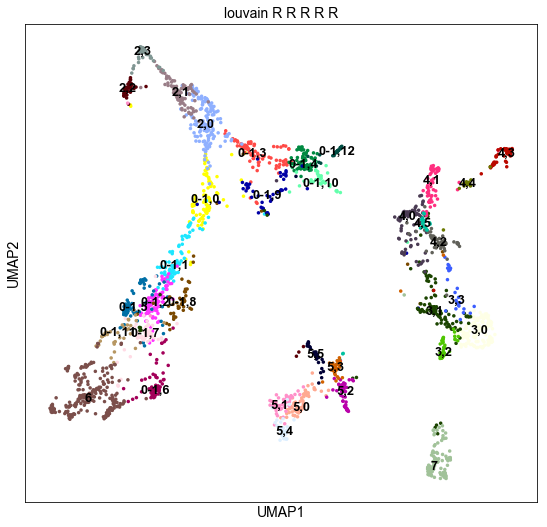

In [51]:
sc.pl.umap(a_EEC, color='louvain_R_R_R_R_R', legend_loc='on data')

### Summarise results

In [52]:
sc.tl.rank_genes_groups(a_EEC, groupby='louvain_R_R_R_R_R')


ranking genes
    finished (0:00:08.70) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids


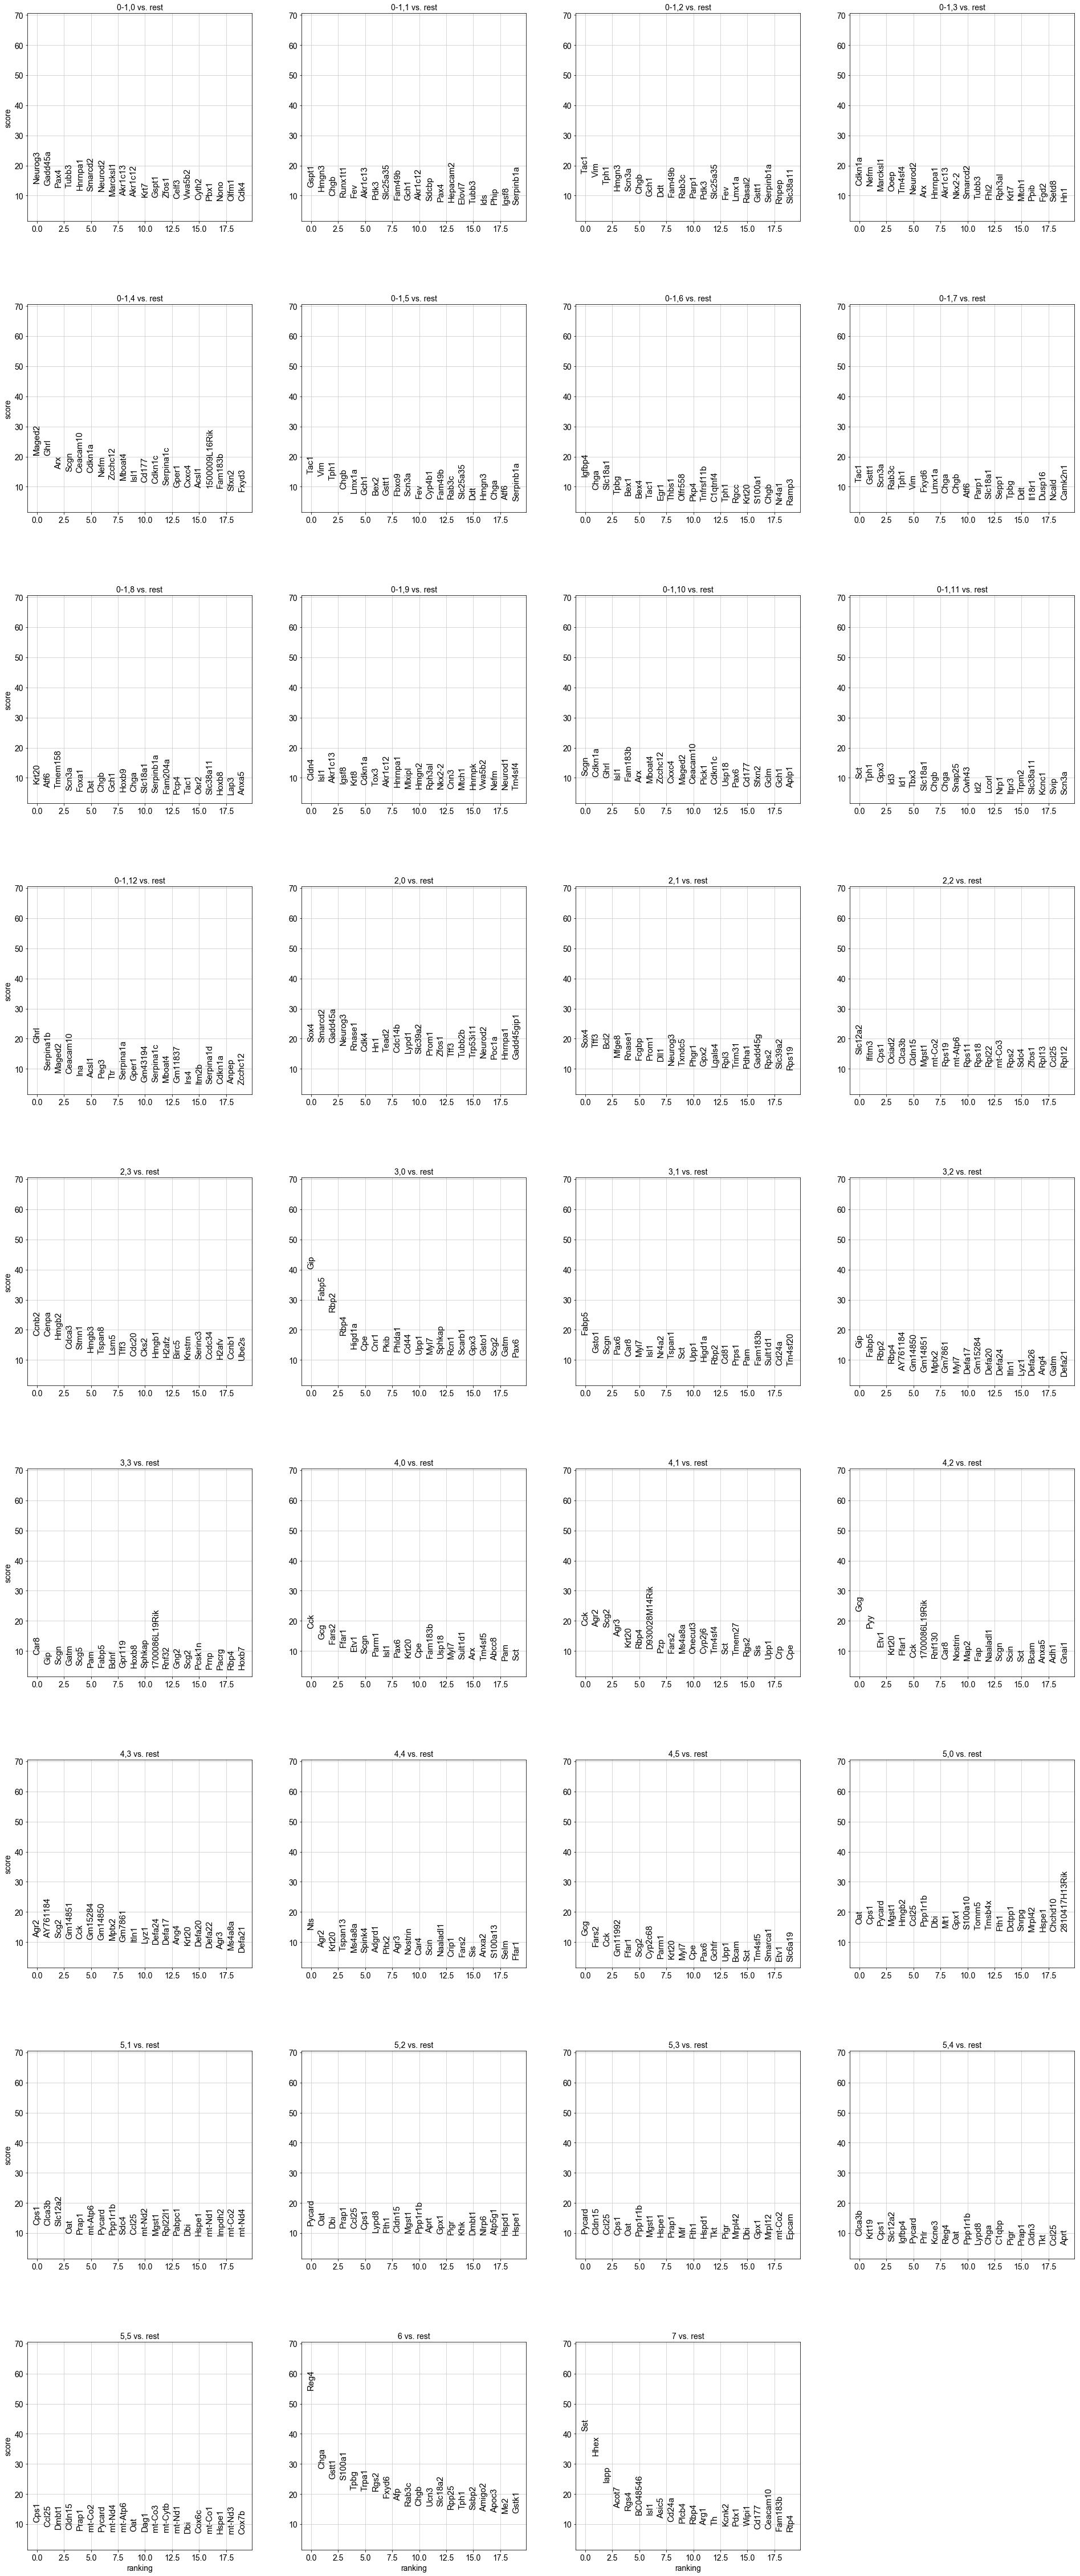

In [53]:
sc.pl.rank_genes_groups(a_EEC, fontsize=15)


In [54]:
genes_to_xls(adata=a_EEC, filename='./../table/EEC_refined_scanpy_v131.xls')


In [55]:
df = np.array([])
for i in a_EEC.uns['rank_genes_groups']['names'].dtype.names:
    d = a_EEC.uns['rank_genes_groups']['names'][i][:10]
    df = np.concatenate([df,d])

In [56]:
genes_EEC = pd.value_counts(df).index

In [57]:
genes_EEC

Index(['Cps1', 'Oat', 'Chgb', 'Krt20', 'Isl1', 'Pycard', 'Chga', 'Scgn', 'Cck',
       'Ccl25',
       ...
       'Ociad2', 'Sst', 'Hspe1', 'Cdc14b', 'Peg3', 'Slc25a35', 'Pdk3', 'Hmgb3',
       'Tox3', 'Ttr'],
      dtype='object', length=195)

In [58]:
genes_EEC_idx = np.flatnonzero(np.in1d(a_EEC.var_names, genes_EEC))


### Create a heatmap for all clusters

Find apposite root cells for pseudotime analysis.

In [59]:
np.flatnonzero(a_EEC.obs['louvain_R_R_R_R_R']== ['2,3'])

array([  75,  107,  148,  234,  257,  270,  317,  329,  425,  428,  536,
        559,  618,  659,  697,  719,  769,  929,  988, 1053, 1077, 1116,
       1139, 1179, 1230, 1319, 1425, 1510, 1521, 1522, 1526, 1596, 1600,
       1613, 1639, 1721, 1727, 1771, 1814, 1904, 2105, 2141, 2156, 2158,
       2236, 2263, 2318])

In [74]:
a_EEC.uns['iroot'] = 75
#sc.pp.neighbors(a_EEC)
sc.tl.paga(a_EEC, groups='louvain_R_R_R_R_R')
sc.tl.diffmap(a_EEC)
sc.tl.dpt(a_EEC)

running partition-based graph abstraction (PAGA)
    finished (0:00:00.47) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.99196553 0.99179584 0.9862577  0.97912854 0.9784301
     0.9743309  0.9717672  0.9599482  0.95280504 0.9464055  0.9424938
     0.939082   0.9383188  0.93129426]
    finished (0:00:00.07) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.00) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


--> added 'pos', the PAGA positions (adata.uns['paga'])


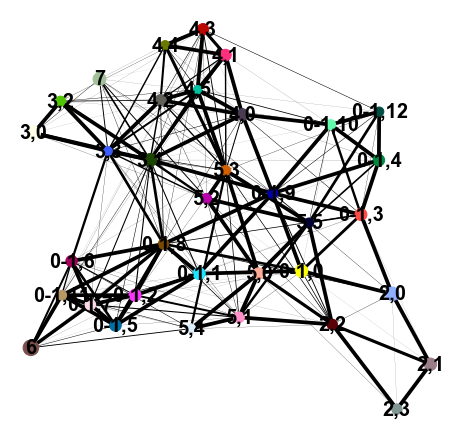

In [61]:
rcParams['figure.figsize']=(7,7)
sc.pl.paga(a_EEC, frameon=False, fontsize=20, edge_width_scale=0.5)


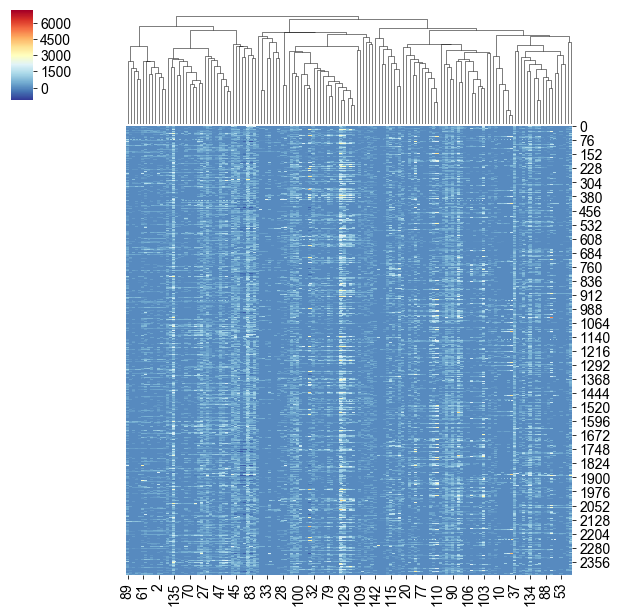

In [62]:
g=sns.clustermap(a_EEC.X[:,genes_EEC_idx].todense(),
                 cmap="RdYlBu_r",row_cluster=False,metric='correlation')

In [63]:
gene_names_diff=a_EEC[:,genes_EEC_idx].var_names[g.dendrogram_col.reordered_ind]

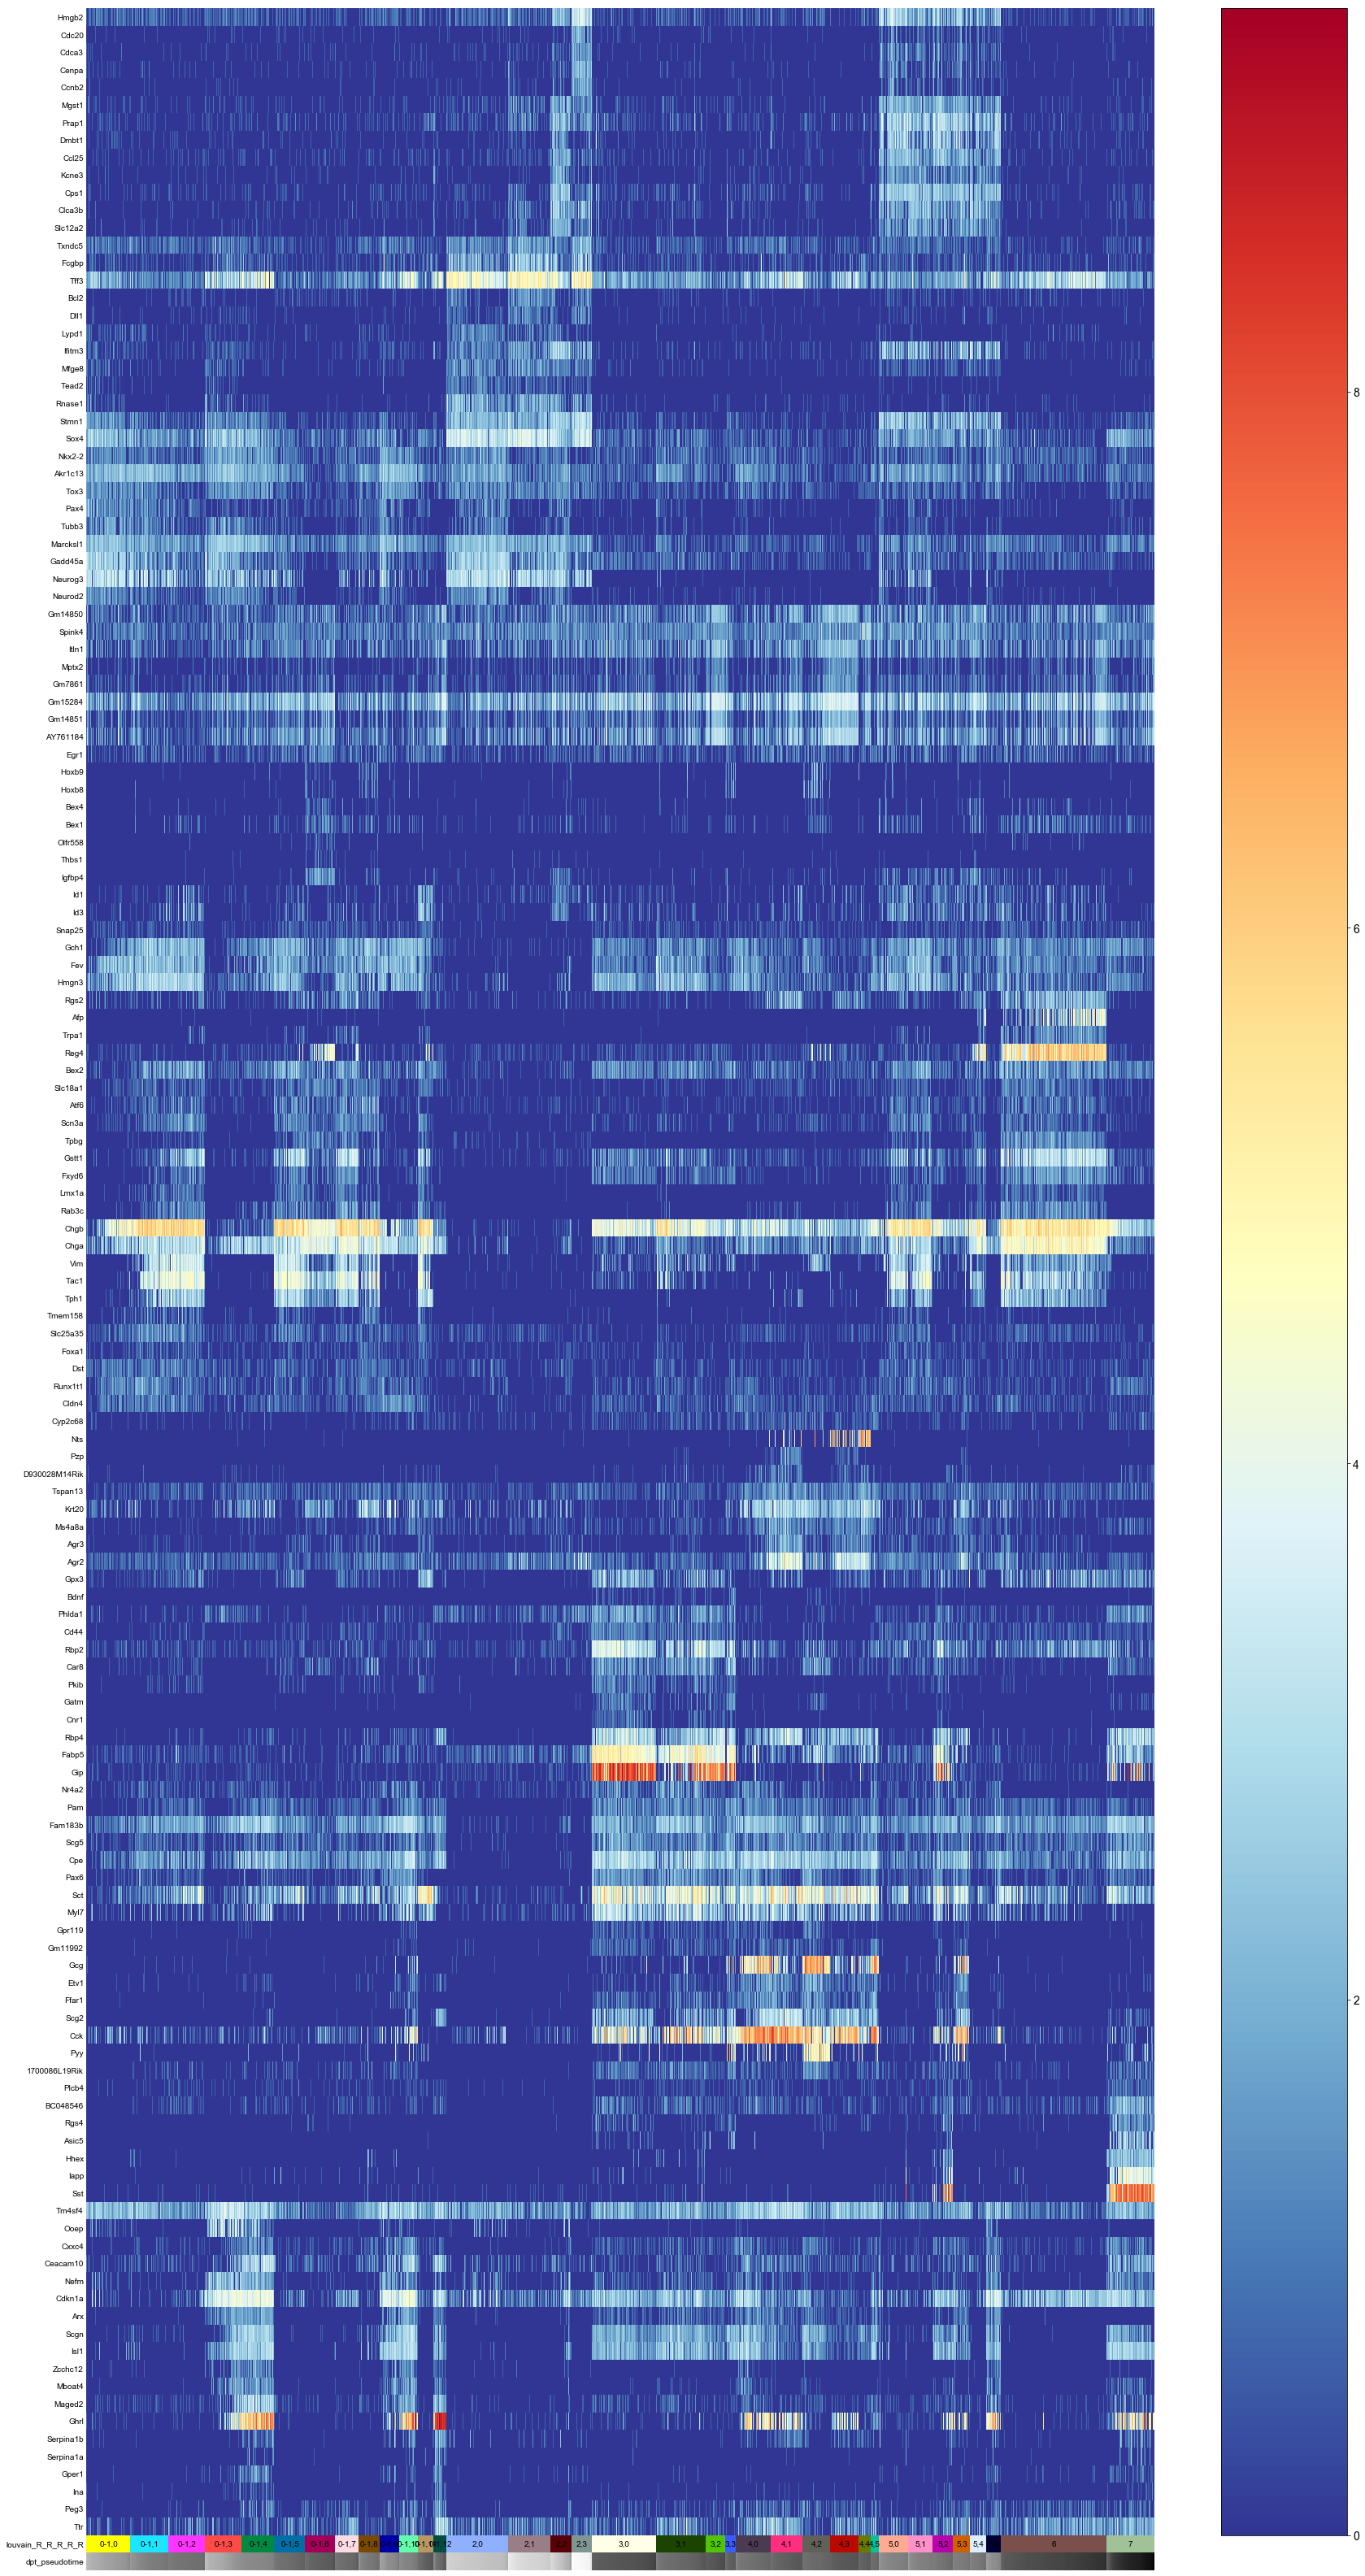

In [64]:
rcParams['figure.figsize']=(30,55)
sc.pl.paga_path(a_EEC, keys=gene_names_diff, 
                nodes=a_EEC.obs['louvain_R_R_R_R_R'].cat.categories,
                color_map="RdYlBu_r")


In [65]:
a_EEC.obs['louvain_R_R_R_R_R'].cat.categories

Index(['0-1,0', '0-1,1', '0-1,2', '0-1,3', '0-1,4', '0-1,5', '0-1,6', '0-1,7',
       '0-1,8', '0-1,9', '0-1,10', '0-1,11', '0-1,12', '2,0', '2,1', '2,2',
       '2,3', '3,0', '3,1', '3,2', '3,3', '4,0', '4,1', '4,2', '4,3', '4,4',
       '4,5', '5,0', '5,1', '5,2', '5,3', '5,4', '5,5', '6', '7'],
      dtype='object')

In [66]:
gene_names = ['Sox4', 'Neurog3', 'Isl1', 'Arx','Pax4', 'Pax6', 'Pdx1', 'Neurod1', 'Neurod2', 
              'Sct', 'Cck', 'Gcg', 'Pyy', 'Ghrl', 'Gal', 'Gip', 'Fabp5', 'Sst', 'Nts', 
              'Tac1', 'Tph1', 'Reg4', 'Chga', 'Chgb'
             ]

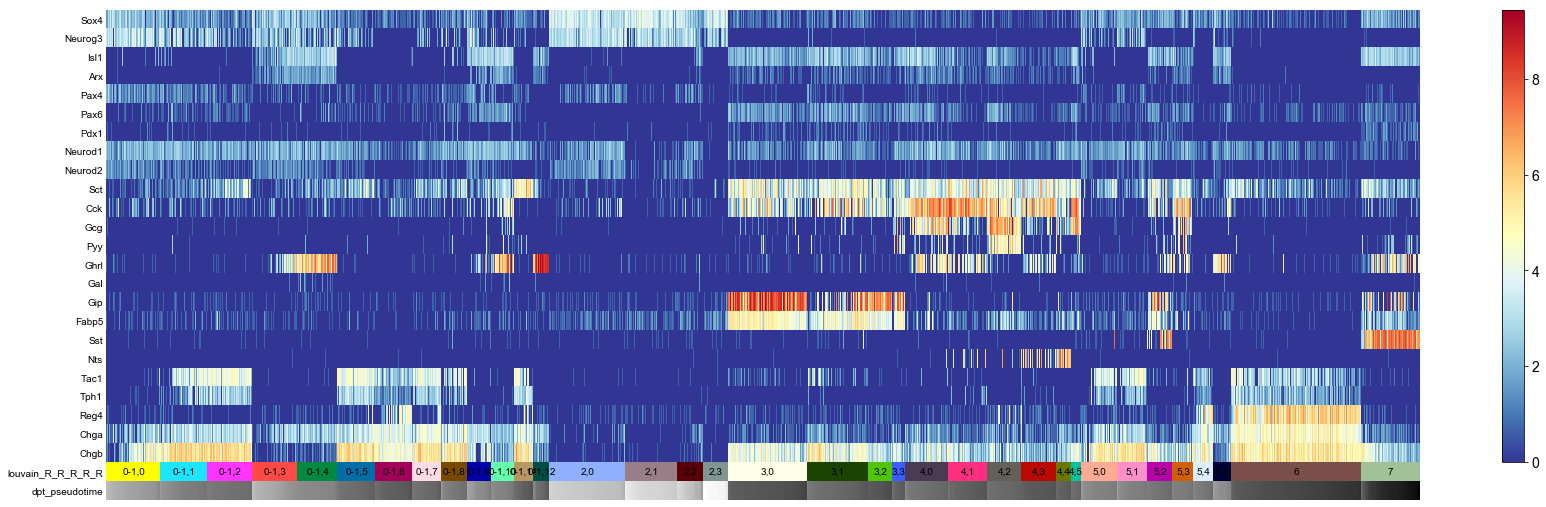

In [67]:
rcParams['figure.figsize']=(30,8)
sc.pl.paga_path(a_EEC, keys=gene_names, 
                nodes=a_EEC.obs['louvain_R_R_R_R_R'].cat.categories,color_map="RdYlBu_r")

Let us annotate the clusters by their marker gene expression.

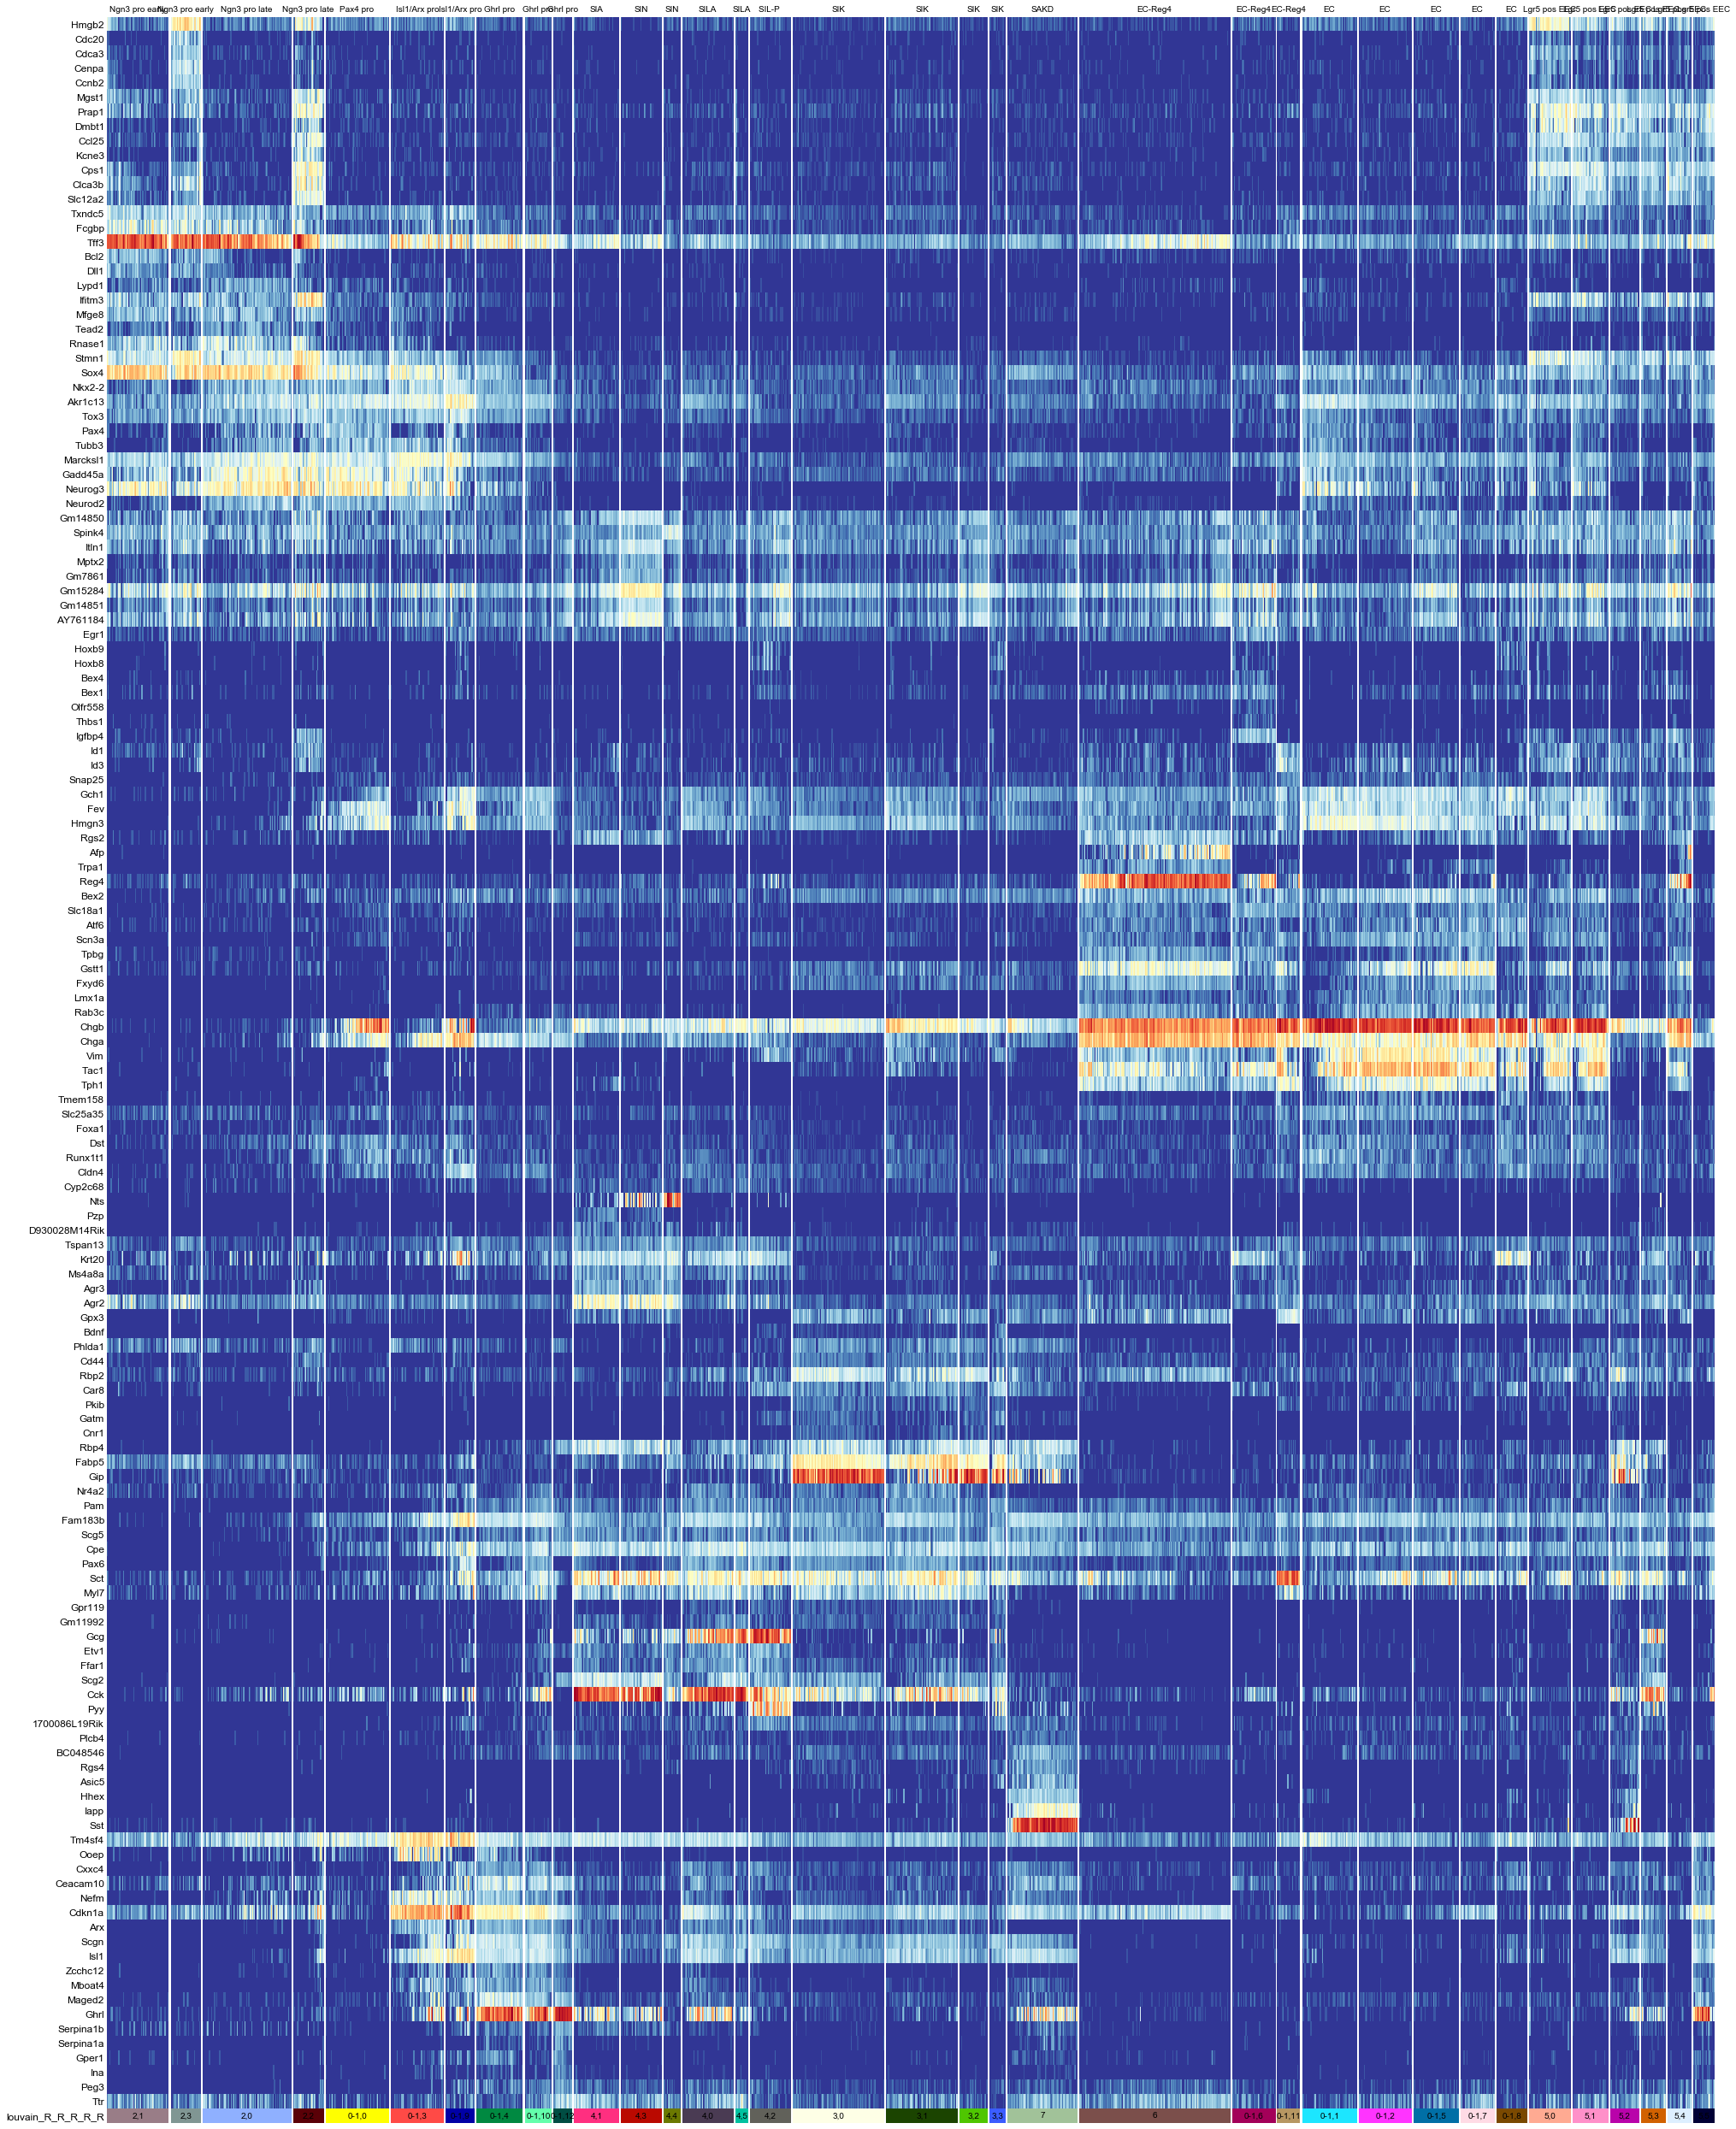

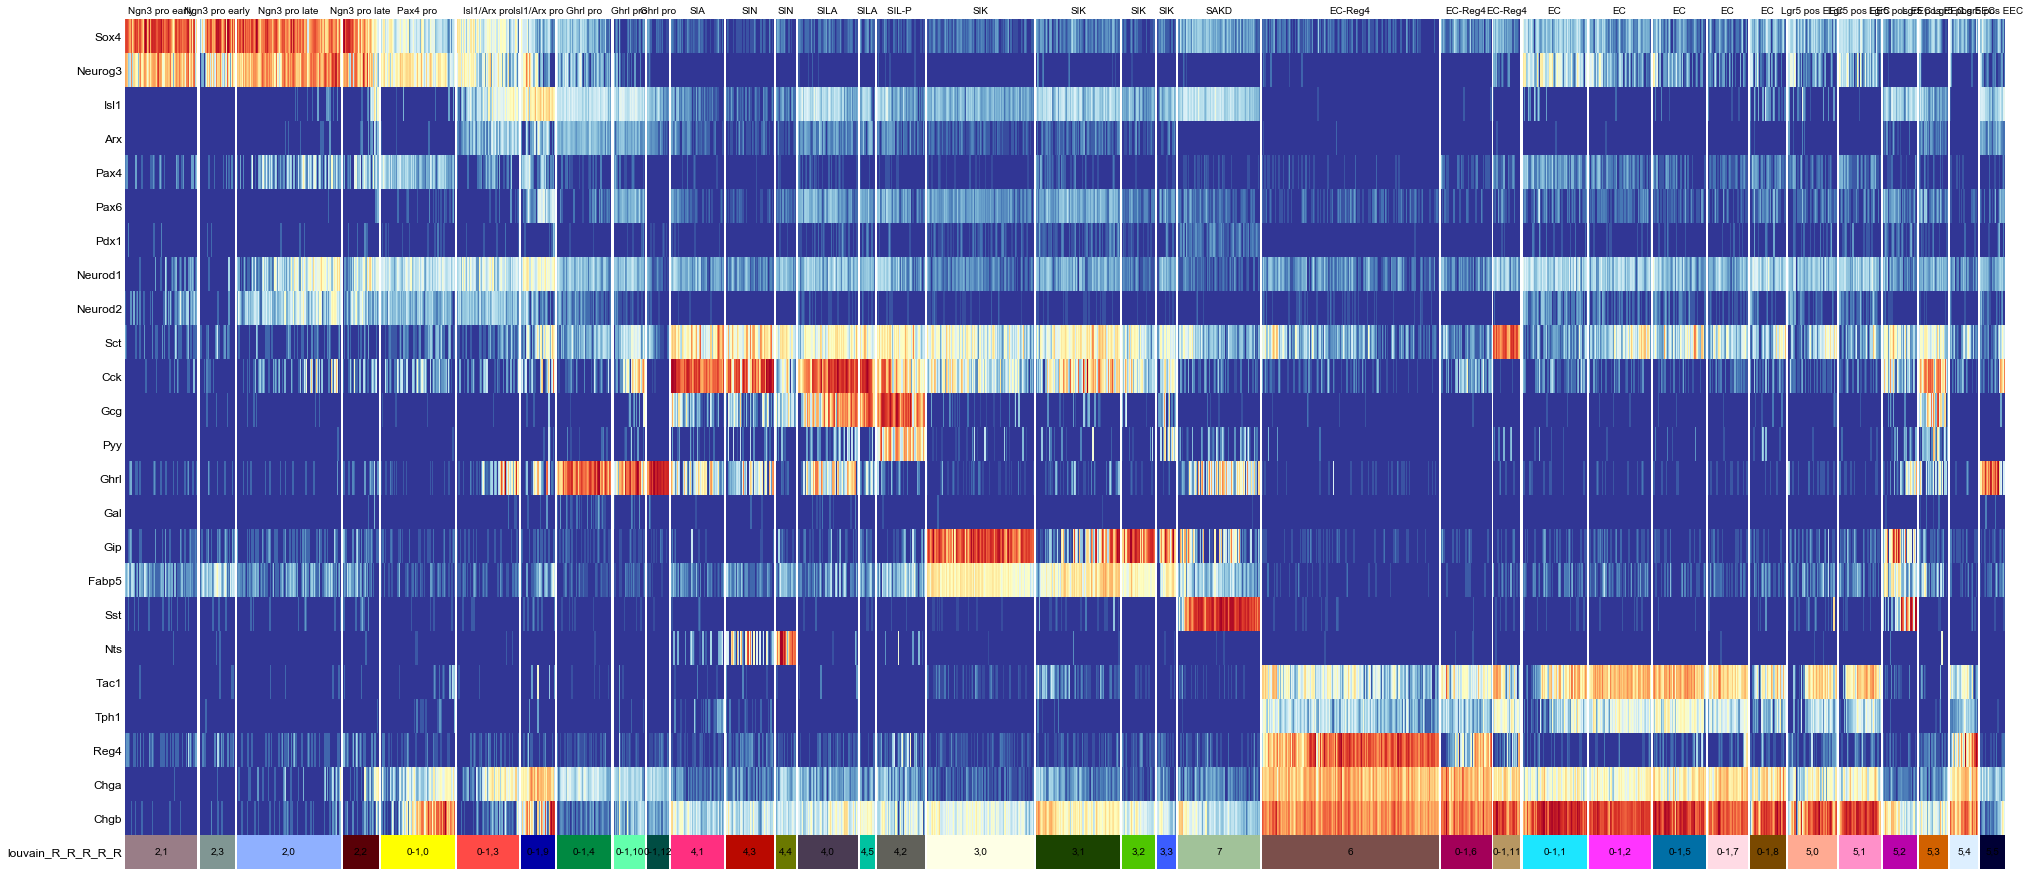

In [75]:
paths = [('Ngn3 pro early', ['2,1']), 
         ('Ngn3 pro early', ['2,3']), 
         ('Ngn3 pro late', ['2,0']), 
         ('Ngn3 pro late', ['2,2']), 
         ('Pax4 pro', ['0-1,0']),   
         ('Isl1/Arx pro', ['0-1,3']), 
         ('Isl1/Arx pro', ['0-1,9']), 
         ('Ghrl pro', ['0-1,4']), 
         ('Ghrl pro', ['0-1,10']), 
         ('Ghrl pro', ['0-1,12']), 
         
         ('SIA', ['4,1']),   
         ('SIN', ['4,3']),  
         ('SIN', ['4,4']),  
         ('SILA',['4,0']), 
         ('SILA',['4,5']), 
         ('SIL-P ', ['4,2']),  
         ('SIK', ['3,0']),  
         ('SIK', ['3,1']),  
         ('SIK', ['3,2']), 
         ('SIK', ['3,3']), 
         ('SAKD', ['7']), 
         
         ('EC-Reg4', ['6']),
         ('EC-Reg4', ['0-1,6']), 
         ('EC-Reg4', ['0-1,11']), 
         
         ('EC', ['0-1,1']), 
         ('EC', ['0-1,2']), 
         ('EC', ['0-1,5']), 
         ('EC', ['0-1,7']), 
         ('EC', ['0-1,8']), 
         
         ('Lgr5 pos EEC', ['5,0']),
         ('Lgr5 pos EEC', ['5,1']), 
          ('Lgr5 pos EEC', ['5,2']), 
         ('Lgr5 pos EEC', ['5,3']), 
          ('Lgr5 pos EEC', ['5,4']), 
         ('Lgr5 pos EEC', ['5,5']) 
        ]

path_ratios= pd.value_counts(a_EEC.obs['louvain_R_R_R_R_R']).values
path_cat =pd.value_counts(a_EEC.obs['louvain_R_R_R_R_R']).index
tmp=np.zeros(len(paths))
for ipath, (descr, path) in enumerate(paths):
    #print(path[1])
    idx = np.flatnonzero(np.in1d(path_cat, path))
    #print(idx)
    tmp[ipath] = path_ratios[idx]
    
tmp = tmp.astype('int')
#path_ratios = np.asarray([path_ratios[i] for i in tmp])
path_ratios = tmp / tmp.sum() *len(path_ratios)


_, axs = pl.subplots(ncols=len(tmp), figsize=(30, 45), 
                     gridspec_kw={'wspace': 0.05, 'left': 0.11,'width_ratios':path_ratios})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(a_EEC, left_margin=0.3, ytick_fontsize=12, color_map='RdYlBu_r',
                   nodes=path, ax=axs[ipath],
                   keys=np.concatenate([gene_names_diff]),
                   annotations=[],
                   show_yticks=True if ipath==0 else False,
                   show_colorbar=False,                        
                   n_avg=2,
                   title='{}'.format(descr),
                   show=False)
#pl.savefig('./figures/aga_EEC.png', dpi=300)
pl.show()

_, axs = pl.subplots(ncols=len(tmp), figsize=(30, 15), 
                     gridspec_kw={'wspace': 0.05, 'left': 0.11,'width_ratios':path_ratios})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(a_EEC, left_margin=0.3, ytick_fontsize=12, color_map='RdYlBu_r',
                   nodes=path, ax=axs[ipath],
                   keys=gene_names,
                   annotations=[],
                   show_yticks=True if ipath==0 else False,
                   show_colorbar=False,                        
                   n_avg=2,
                   title='{}'.format(descr),
                   show=False)
#pl.savefig('./figures/aga_EEC.png', dpi=300)
pl.show()


### Rename groups and merge

In [76]:
a_EEC.obs['EEC_group_final']=a_EEC.obs['louvain_R_R_R_R_R']
a_EEC.obs['EEC_group_final']= a_EEC.obs['EEC_group_final'].cat.add_categories([
    'Lgr5 pos EEC', 'Ngn3 pro', 
    'Pax4 pro','EC',  'EC-Reg4', 'Isl1/Arx pro', 'Ghrl pro', 'SIA', 
    'SILA','SIN', 'SIL-P', 'SIK', 'SAKD'
   ])
a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], 
                                     ['2,0','2,1','2,2', '2,3'])] = np.repeat(
    'Ngn3 pro', np.in1d(a_EEC.obs['EEC_group_final'], ['2,0','2,1','2,2', '2,3']).sum())
#a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], 
#                                     ['6,0','6,3', '6,4'])] = np.repeat(
#    'Ngn3 pro late', np.in1d(a_EEC.obs['EEC_group_final'], ['6,0', '6,3', '6,4']).sum())
a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], 
                                     ['0-1,0'])] = np.repeat(
    'Pax4 pro', np.in1d(a_EEC.obs['EEC_group_final'], ['0-1,0']).sum())
a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], 
                                     ['0-1,3', '0-1,9'])] = np.repeat(
    'Isl1/Arx pro', np.in1d(a_EEC.obs['EEC_group_final'], ['0-1,3', '0-1,9']).sum())
a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], 
                                     ['0-1,4', '0-1,10', '0-1,12'])] = np.repeat(
    'Ghrl pro', np.in1d(a_EEC.obs['EEC_group_final'], ['0-1,4', '0-1,10', '0-1,12']).sum())
a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], 
                                     ['4,1'])] = np.repeat(
    'SIA', np.in1d(a_EEC.obs['EEC_group_final'], ['4,1']).sum())
a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], ['4,0', '4,5'])] = np.repeat(
    'SILA', np.in1d(a_EEC.obs['EEC_group_final'], ['4,0', '4,5']).sum())
a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], ['4,2'])] = np.repeat(
    'SIL-P', np.in1d(a_EEC.obs['EEC_group_final'], ['4,2']).sum())
a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], ['4,3', '4,4'])] = np.repeat(
    'SIN', np.in1d(a_EEC.obs['EEC_group_final'], ['4,3','4,4']).sum())
a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], 
                                     ['7'])] = np.repeat(
    'SAKD', np.in1d(a_EEC.obs['EEC_group_final'],  ['7']).sum())
a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], 
                                     ['3,0','3,1', '3,2','3,3'])] = np.repeat(
    'SIK', np.in1d(a_EEC.obs['EEC_group_final'], ['3,0','3,1', '3,2','3,3']).sum())
a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], 
                                     ['0-1,1','0-1,2', '0-1,5','0-1,7', '0-1,8'])] = np.repeat(
    'EC', np.in1d(a_EEC.obs['EEC_group_final'], ['0-1,1','0-1,2', '0-1,5','0-1,7', '0-1,8']).sum())
a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], 
                                     ['0-1,6','0-1,11','6'])] = np.repeat(
    'EC-Reg4', np.in1d(a_EEC.obs['EEC_group_final'],  ['0-1,6','0-1,11','6']).sum())
a_EEC.obs['EEC_group_final'][np.in1d(a_EEC.obs['EEC_group_final'], 
                                     ['5,0','5,1', '5,2', '5,3', '5,4','5,5'])] = np.repeat(
    'Lgr5 pos EEC', np.in1d(a_EEC.obs['EEC_group_final'], ['5,0','5,1', '5,2', '5,3', '5,4','5,5']).sum())
a_EEC.obs['EEC_group_final']=a_EEC.obs['EEC_group_final'].cat.remove_unused_categories()

In [77]:
a_EEC.obs['EEC_group_final'].cat.categories

Index(['Lgr5 pos EEC', 'Ngn3 pro', 'Pax4 pro', 'EC', 'EC-Reg4', 'Isl1/Arx pro',
       'Ghrl pro', 'SIA', 'SILA', 'SIN', 'SIL-P', 'SIK', 'SAKD'],
      dtype='object')

### Create final graph

In [78]:
sc.tl.paga(a_EEC, groups='EEC_group_final')

running partition-based graph abstraction (PAGA)
    finished (0:00:00.27) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


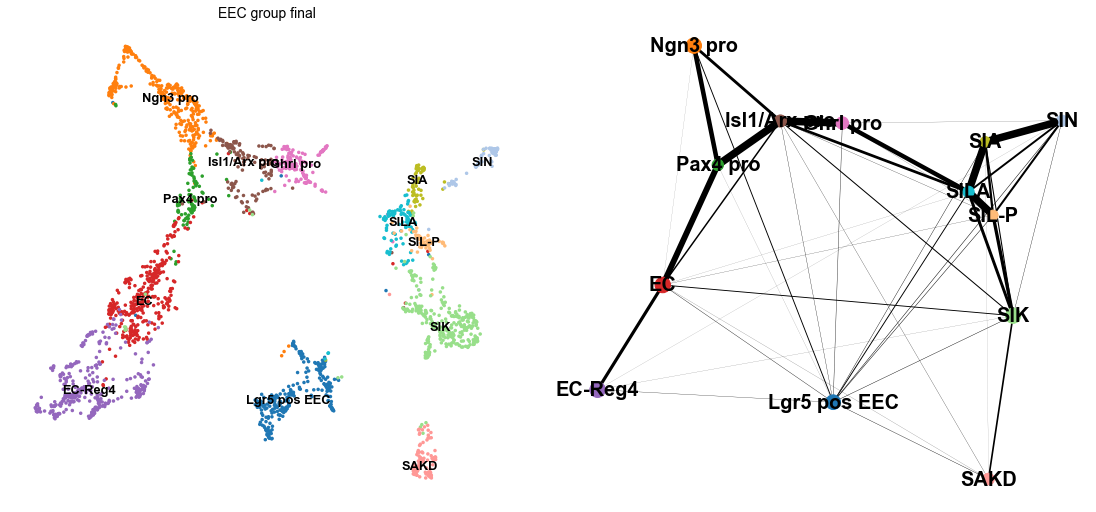

In [79]:
rcParams['figure.figsize']=(8,8)
sc.pl.paga_compare(a_EEC,basis='umap', fontsize=20, frameon=False)

--> added 'pos', the PAGA positions (adata.uns['paga'])


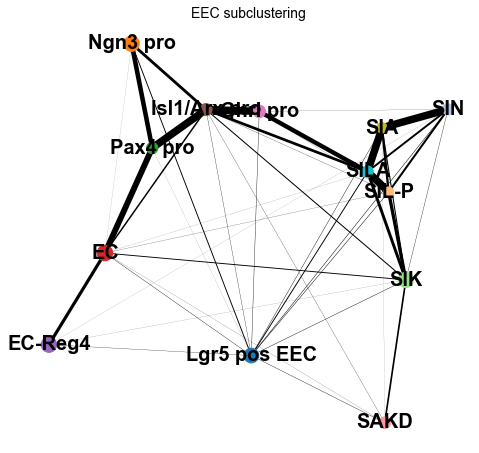

In [80]:
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    a_EEC, prediction='EEC_group_final', reference='EEC_group_final')
asso_colors = sc.utils.get_associated_colors_of_groups(a_EEC.uns['EEC_group_final_colors'], 
                                                       asso_matrix)
rcParams['figure.figsize']=(7,7)
sc.pl.paga(a_EEC,# return_pos=True, 
           frameon=False, pos=a_EEC.uns['paga']['pos'],
                title='EEC subclustering',
                root=10,edge_width_scale=1,
                #color=asso_colors, 
                labels=asso_names,
                fontsize=20
               #save='180326_aga_control_named_woly.pdf'
               )

Recompute differential genes. 

In [81]:
sc.tl.rank_genes_groups(a_EEC, groupby='EEC_group_final')

ranking genes
    finished (0:00:03.34) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids


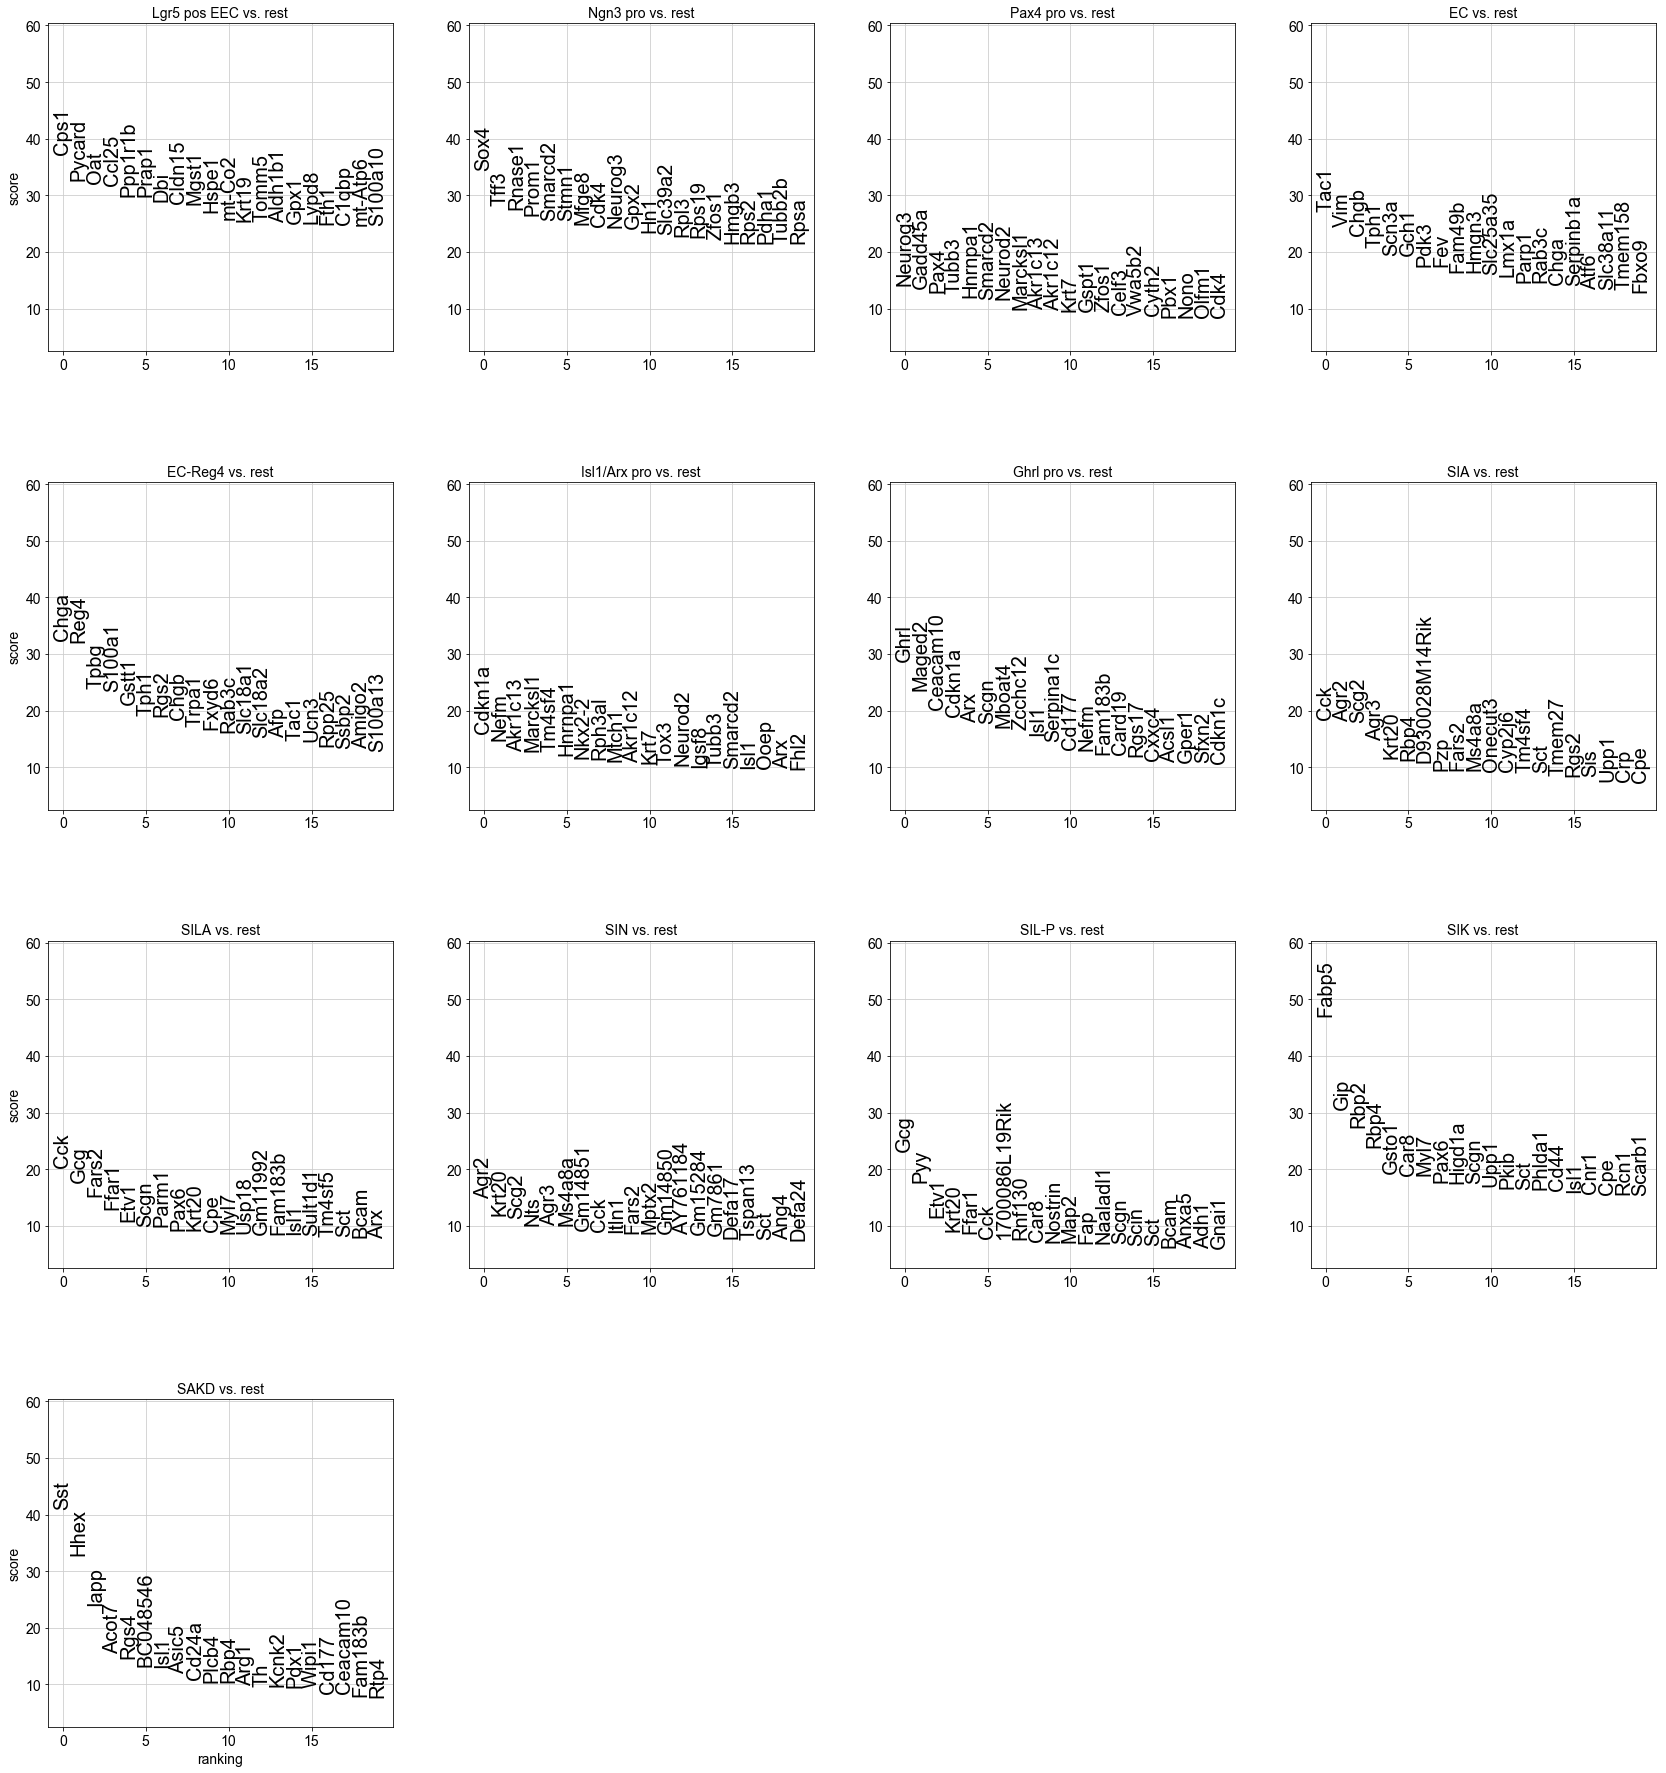

In [82]:
sc.pl.rank_genes_groups(a_EEC, fontsize=20)

In [83]:
df = np.array([])
for i in a_EEC.uns['rank_genes_groups']['names'].dtype.names:
    d = a_EEC.uns['rank_genes_groups']['names'][i][:15]
    df = np.concatenate([df,d])

In [84]:
genes_EEC = pd.value_counts(df).index

In [85]:
genes_EEC

Index(['Scgn', 'Cck', 'Krt20', 'Fars2', 'Rbp4', 'Isl1', 'Fam183b', 'Zfos1',
       'Akr1c13', 'Tm4sf4',
       ...
       'Zcchc12', 'Slc39a2', 'Mfge8', 'Tox3', 'Rnf130', 'Cldn15', 'Prap1',
       'Maged2', 'Fap', 'Map2'],
      dtype='object', length=150)

In [86]:
genes_EEC_idx = np.flatnonzero(np.in1d(a_EEC.var_names, genes_EEC))


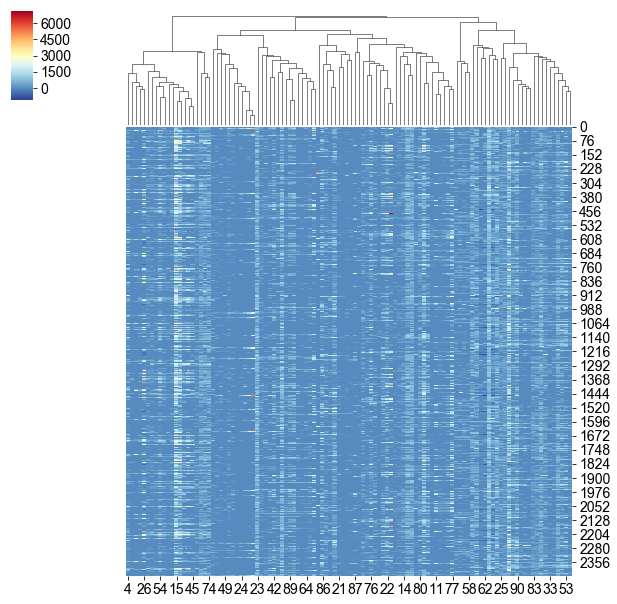

In [87]:
g=sns.clustermap(a_EEC.X[:,genes_EEC_idx].todense(),cmap="RdYlBu_r",row_cluster=False,metric='correlation')

In [88]:
gene_names_diff=a_EEC[:,genes_EEC_idx].var_names[g.dendrogram_col.reordered_ind]

Replot heatmap with merged groups.

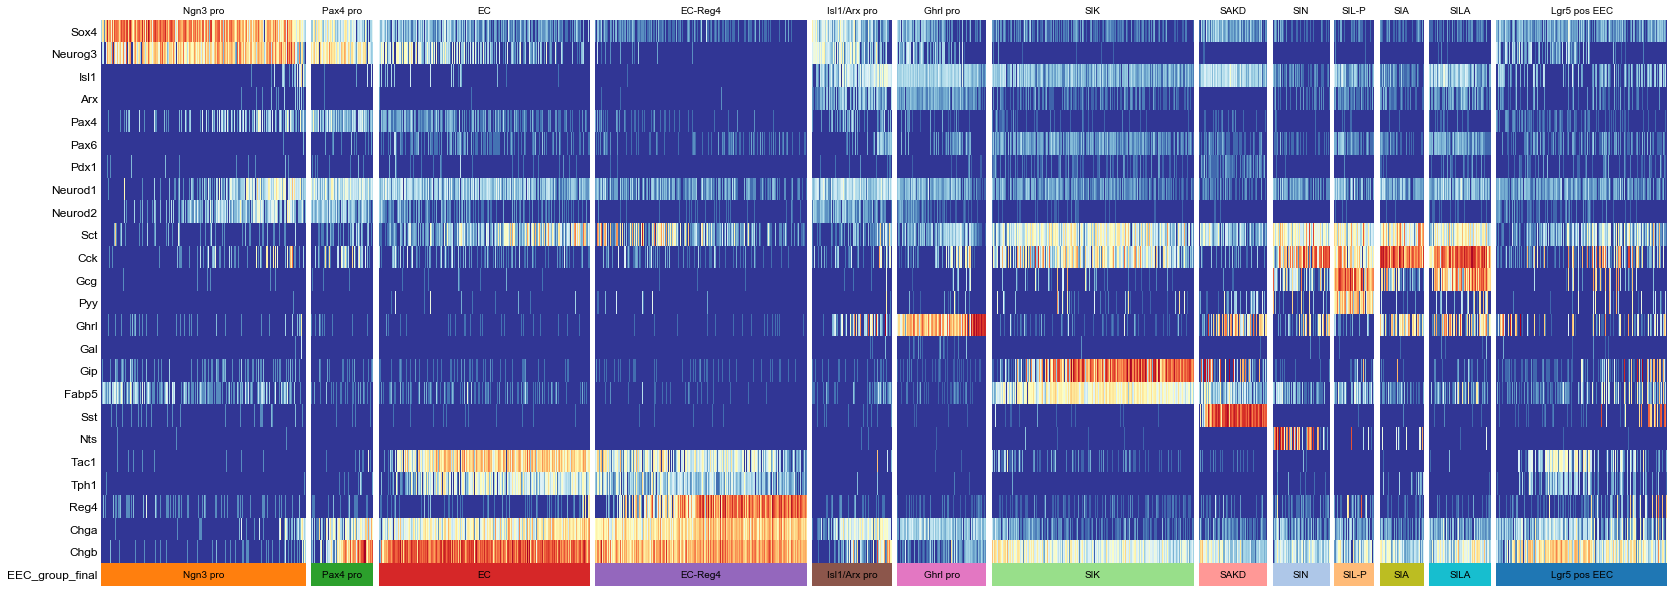

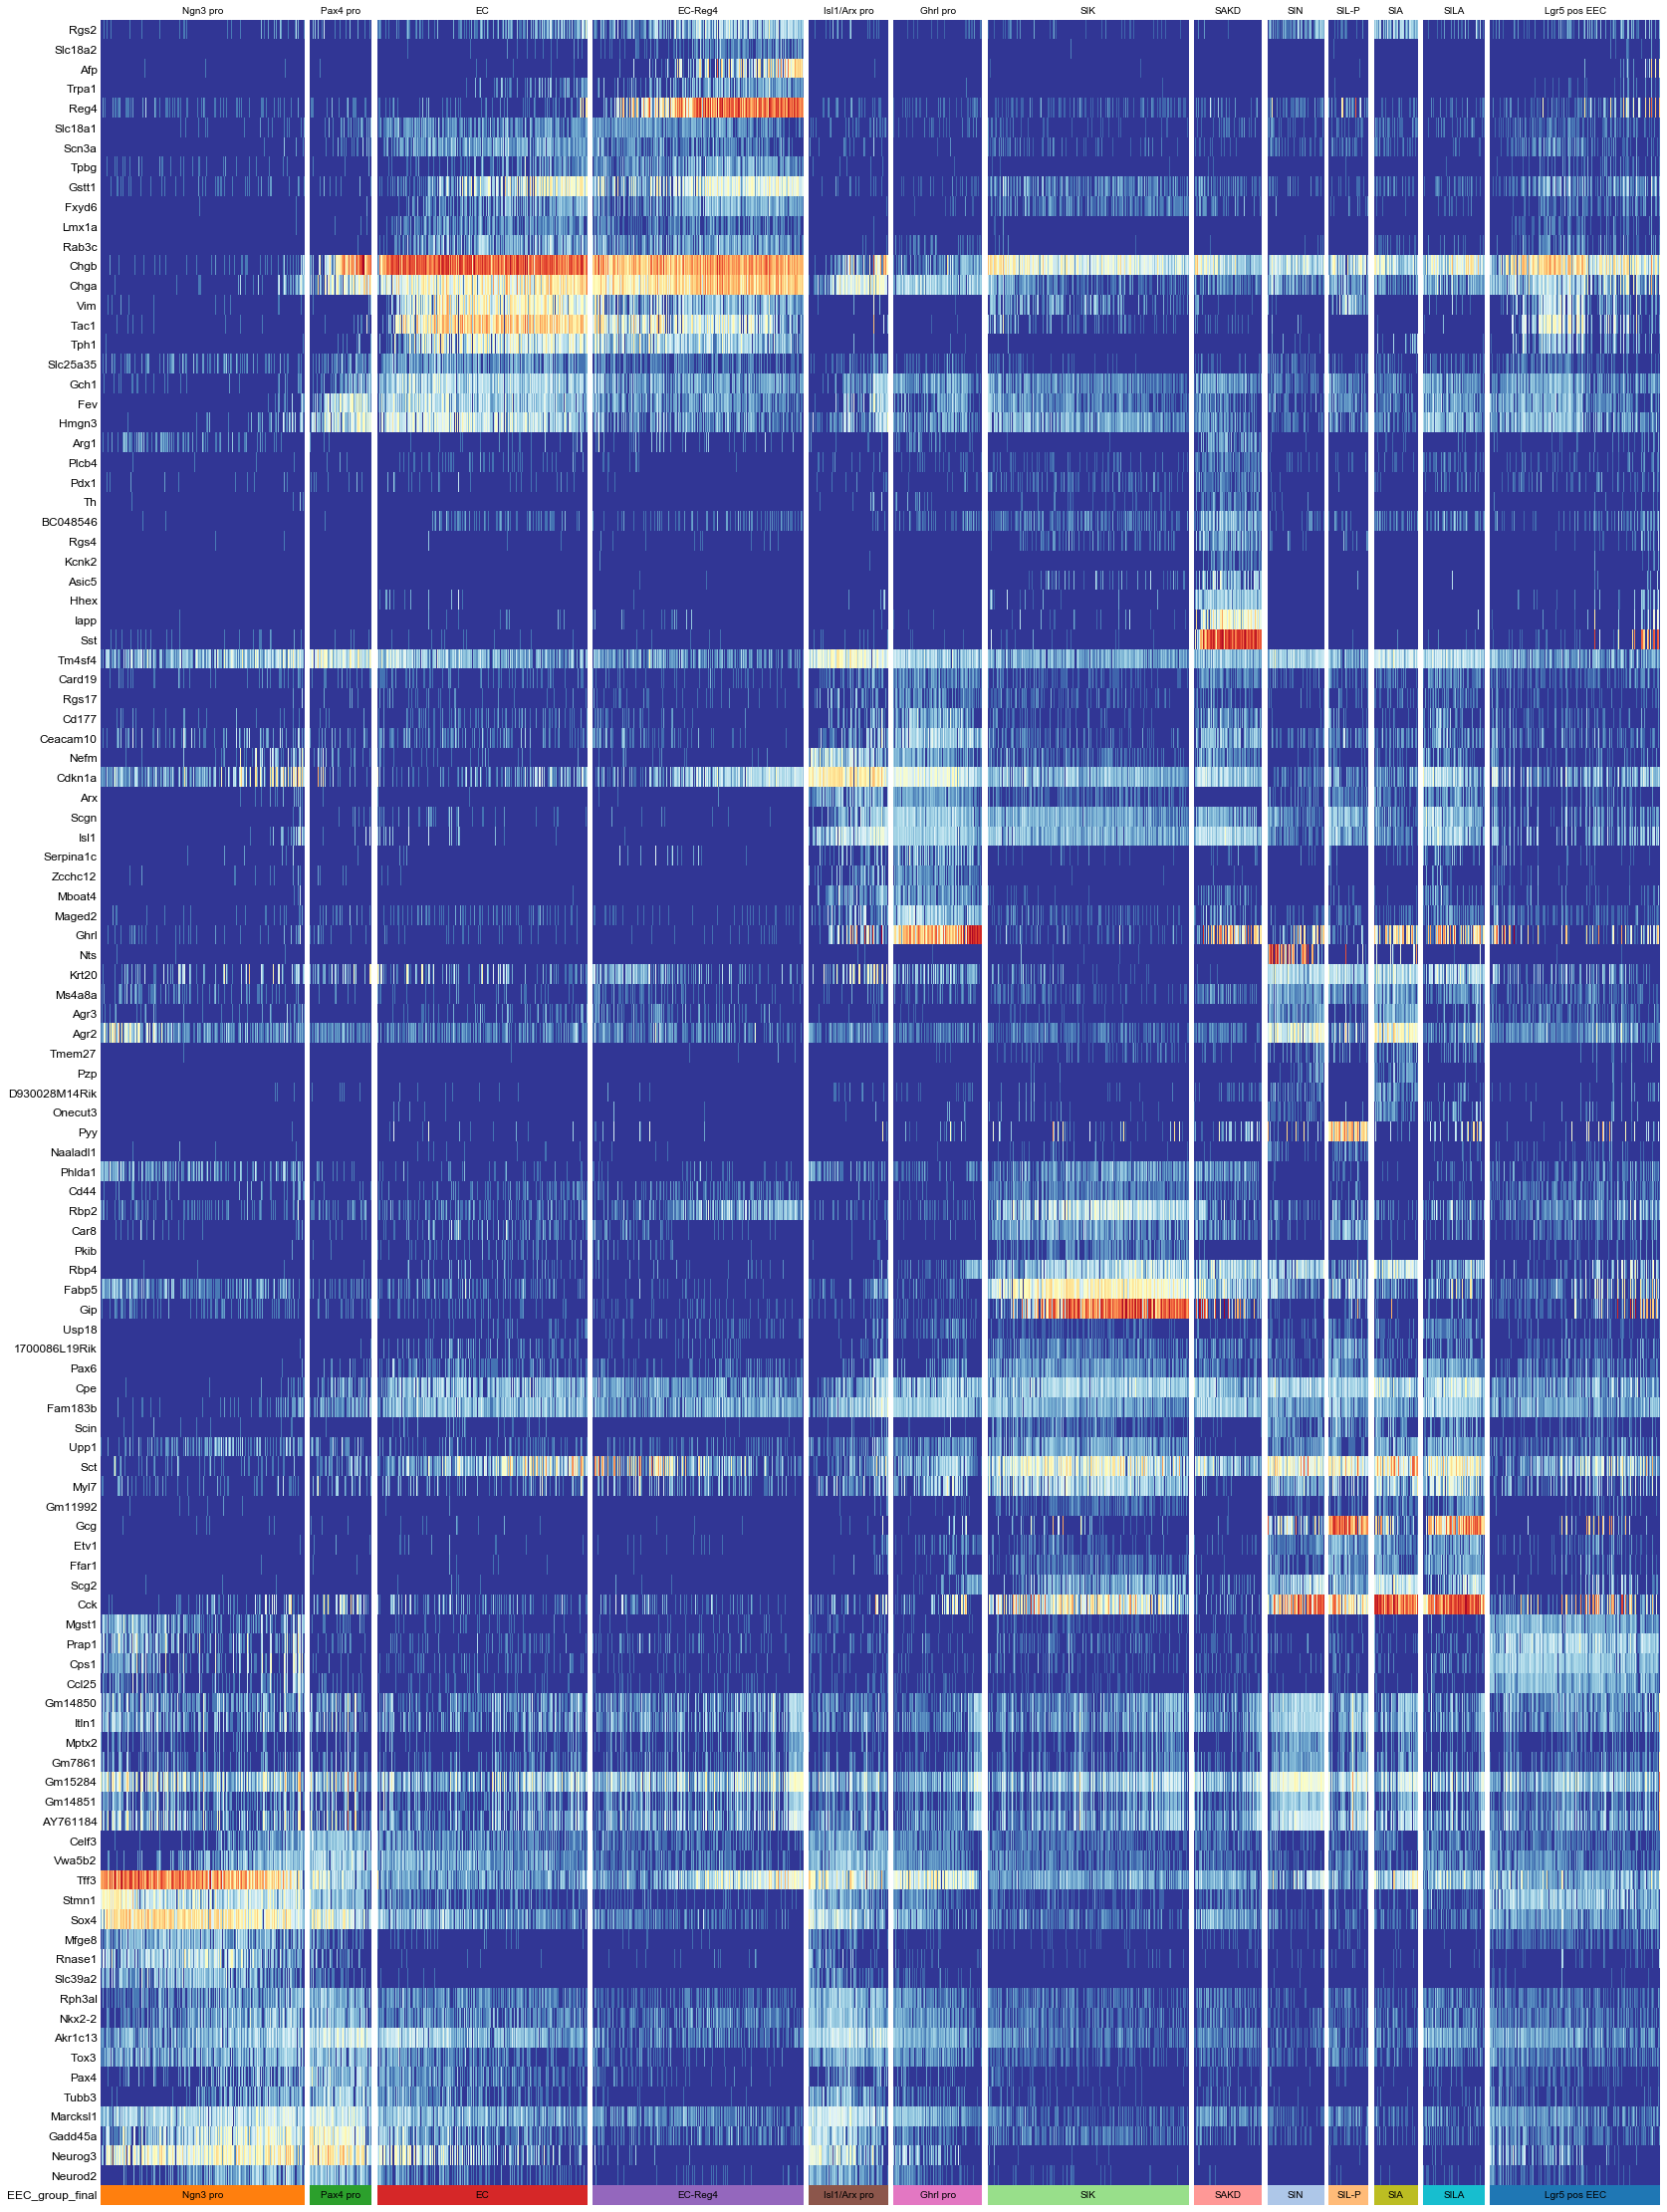

In [89]:
paths = [
         #('Ngn3 pro early', ['Ngn3 pro early']),
         ('Ngn3 pro', ['Ngn3 pro']),
         ('Pax4 pro', ['Pax4 pro']),
         ('EC', ['EC']),
         ('EC-Reg4', ['EC-Reg4']),
         ('Isl1/Arx pro', ['Isl1/Arx pro']), 
         ('Ghrl pro', ['Ghrl pro']),
         ('SIK', ['SIK']),
         ('SAKD',['SAKD']),
         ('SIN', ['SIN']),          
         ('SIL-P', ['SIL-P']),
         ('SIA',['SIA']),
         ('SILA', ['SILA']),
         ('Lgr5 pos EEC', ['Lgr5 pos EEC'])
          
         
        ]


path_ratios= pd.value_counts(a_EEC.obs['EEC_group_final']).values
path_cat = pd.value_counts(a_EEC.obs['EEC_group_final']).index
tmp=np.zeros(len(path_cat))
for ipath, (descr, path) in enumerate(paths):
    #print(path[1])
    idx = np.flatnonzero(np.in1d(path_cat, path))
    #print(idx)
    tmp[ipath] = path_ratios[idx]
    
tmp = tmp.astype('int')
#path_ratios = np.asarray([path_ratios[i] for i in tmp])
path_ratios = tmp / tmp.sum() *len(path_ratios)

_, axs = pl.subplots(ncols=len(tmp), figsize=(25, 10), 
                     gridspec_kw={'wspace': 0.05, 'left': 0.11,'width_ratios':path_ratios})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(a_EEC, left_margin=0.3, ytick_fontsize=12, color_map='RdYlBu_r',
                   nodes=path, ax=axs[ipath],
                   keys=gene_names,
                   annotations=[],
                   show_yticks=True if ipath==0 else False,
                   show_colorbar=False,                        
                   n_avg=1,
                   title='{}'.format(descr),
                   show=False)
#pl.savefig('./figures/aga_EEC.png', dpi=300)
pl.show()


_, axs = pl.subplots(ncols=len(tmp), figsize=(25, 40), 
                     gridspec_kw={'wspace': 0.05, 'left': 0.11,'width_ratios':path_ratios})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath, (descr, path) in enumerate(paths):
    sc.pl.paga_path(a_EEC, left_margin=0.3, ytick_fontsize=12, color_map='RdYlBu_r',
                   nodes=path, ax=axs[ipath],
                   keys=gene_names_diff,
                   annotations=[],
                   show_yticks=True if ipath==0 else False,
                   show_colorbar=False,                        
                   n_avg=1,
                   title='{}'.format(descr),
                   show=False)
#pl.savefig('./figures/aga_EEC.png', dpi=300)
pl.show()

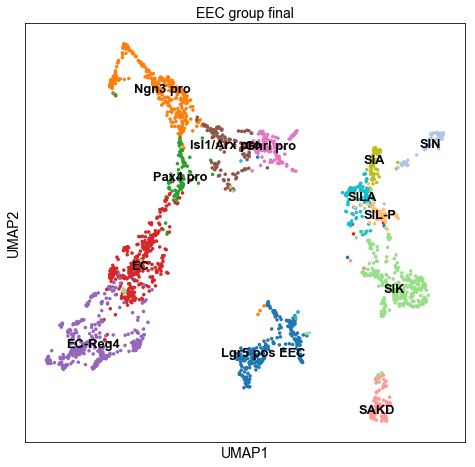

In [90]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(a_EEC, color='EEC_group_final', size=50, legend_loc='on data')

Create a violin plot for each gene.

In [91]:
df = pd.DataFrame()
keys = np.concatenate([gene_names, ['Gast', 'Nkx2-2', 'Foxa1', 'Foxa2', 'Foxa3']])
groups_key = 'EEC_group_final'
df['hue'] = a_EEC.obs[groups_key].astype(str).values
df['hue'] = df['hue'].astype('category')
df['hue'] = df['hue'].cat.reorder_categories(a_EEC.obs[groups_key].cat.categories)

for key in keys:
    X_col = a_EEC[:, key].X
    df[key]=a_EEC[:, key].X


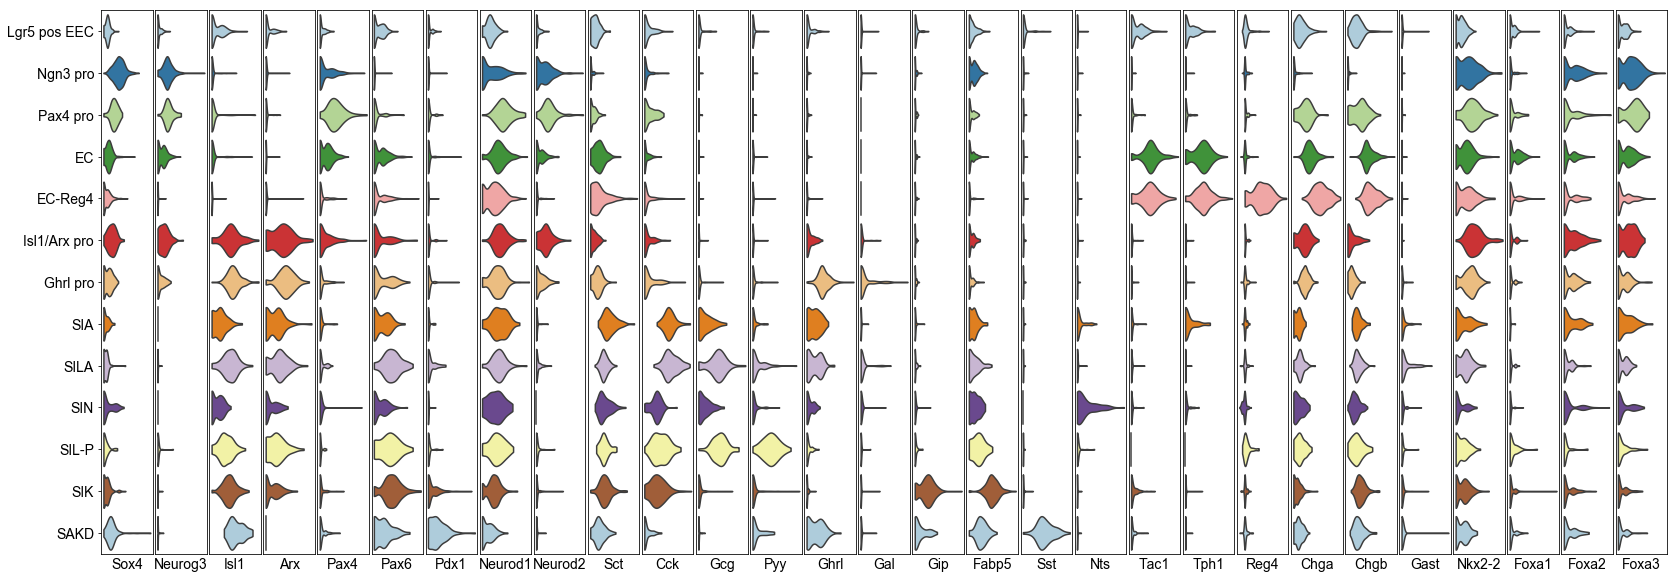

In [92]:
_, axs = pl.subplots(ncols=len(keys), figsize=(25, 10), gridspec_kw={'wspace': 0.05, 'left': 0.11})
pl.subplots_adjust(left=0.05, right=0.98, top=0.88)
for ipath in range(0,len(keys)):
    g=sns.violinplot(x=keys[ipath],y='hue', data=df,ax=axs[ipath], cut=0, scale="width",
                   show_yticks=True if ipath==0 else False, palette="Paired", inner=None)
    g.set(yticks=range(0,len(a_EEC.obs[groups_key].cat.categories)) if ipath==0 else [])
    g.set(xticks=[])
    g.set(ylabel='')
#pl.savefig('./figures/aga_EEC.png', dpi=300)
pl.show()


In [93]:
a_EEC.obs['EEC_group_final'].to_csv('./../data/EEC_final_clustering.csv')

Merge cell type annotation with full dataset.

In [94]:
pd.crosstab(adata_ctrl.obs['refined_clustering'], adata_ctrl.obs['cell_type'])

cell_type                   EEC  Enterocyte  Enterocyte progenitor  Goblet  \
refined_clustering                                                           
EEC                        2383           0                      0      47   
Enterocyte                    0        5294                    444       0   
Enterocyte progenitor         0         259                   5784       0   
Goblet cell                   0           0                      0    4335   
Goblet progenitor             0           0                      0    1512   
ISC                           0           2                    341       0   
Paneth 1                      0           0                      0       0   
Paneth 2                      0           0                      0       0   
Paneth primed ISC             0           6                    891       0   
Paneth pro                    0           0                      0       0   
Sox4+ early EE progenitor     0           0                      0     443   
Tuft 1                        0           0                      0       0   
Tuft 2                        0           0                      0       0   
Tuft progenitor               0           0                      0       0   
early Goblet                  0           0                      0    1511   

cell_type                   ISC  Paneth  Tuft  
refined_clustering                             
EEC                           0       0     0  
Enterocyte                  119       0     0  
Enterocyte progenitor      4662       0     0  
Goblet cell                   0       0     0  
Goblet progenitor             0       0     0  
ISC                        8495       0     0  
Paneth 1                      0   14548     0  
Paneth 2                      0     923     0  
Paneth primed ISC           825       0     0  
Paneth pro                    0    1325     0  
Sox4+ early EE progenitor     0       0     0  
Tuft 1                        0       0   439  
Tuft 2                        0       0   832  
Tuft progenitor               0       0   820  
early Goblet                  0       0     0

In [95]:
adata_ctrl.obs['refined_clustering'] = pd.concat(
    [a_EEC.obs['EEC_group_final'], 
     adata_ctrl.obs['refined_clustering'][np.invert(np.in1d(adata_ctrl.obs['refined_clustering'],
                                                      ['EEC']))]])

In [96]:
pd.value_counts(adata_ctrl.obs['refined_clustering'])

Paneth 1                     14548
Enterocyte progenitor        10705
ISC                           8838
Enterocyte                    5857
Goblet cell                   4335
Paneth primed ISC             1722
Goblet progenitor             1512
early Goblet                  1511
Paneth pro                    1325
Paneth 2                       923
Tuft 2                         832
Tuft progenitor                820
Sox4+ early EE progenitor      443
Tuft 1                         439
EC-Reg4                        343
EC                             342
Ngn3 pro                       332
SIK                            327
Lgr5 pos EEC                   277
Ghrl pro                       144
Isl1/Arx pro                   129
SAKD                           110
Pax4 pro                       100
SILA                           100
SIN                             91
SIA                             71
SIL-P                           64
Name: refined_clustering, dtype: int64

# Create major and progenitor cell type annotation

Create major cell type categories and progenitor-mature classification.

In [97]:
adata_ctrl.obs['refined_clustering'] = adata_ctrl.obs['refined_clustering'].astype('category')

In [98]:
adata_ctrl.obs['refined_clustering'].cat.categories

Index(['EC', 'EC-Reg4', 'Enterocyte', 'Enterocyte progenitor', 'Ghrl pro',
       'Goblet cell', 'Goblet progenitor', 'ISC', 'Isl1/Arx pro',
       'Lgr5 pos EEC', 'Ngn3 pro', 'Paneth 1', 'Paneth 2', 'Paneth primed ISC',
       'Paneth pro', 'Pax4 pro', 'SAKD', 'SIA', 'SIK', 'SIL-P', 'SILA', 'SIN',
       'Sox4+ early EE progenitor', 'Tuft 1', 'Tuft 2', 'Tuft progenitor',
       'early Goblet'],
      dtype='object')

In [99]:
adata_ctrl.obs['refined_clustering']=adata_ctrl.obs['refined_clustering'].cat.rename_categories(
      ['EC', 'EC-Reg4', 'Enterocyte', 'Enterocyte progenitor', 'Ghrl progenitor',
       'Goblet cell','Goblet progenitor', 'ISC', 'Isl1/Arx progenitor', 'Lgr5+ EEC', 
       'Ngn3 progenitor','Paneth 1', 'Paneth 2', 'Paneth primed ISC',
       'Paneth progenitor', 'Pax4 progenitor', 'SAKD', 'SIA', 'SIK', 'SIL-P', 'SILA', 'SIN',
       'Sox4+ early EE progenitor',  'Tuft 1', 'Tuft 2',
       'Tuft progenitor','early Goblet'])

In [100]:
adata_ctrl.obs['major_cell_type']=adata_ctrl.obs['refined_clustering'].cat.add_categories([
    'EEC', 'Paneth cell', 'Tuft cell'])
adata_ctrl.obs['major_cell_type'][np.in1d(adata_ctrl.obs['refined_clustering'], 
                        ['Tuft progenitor', 'Tuft 1', 'Tuft 2'])] = np.repeat(
    'Tuft cell', np.in1d(adata_ctrl.obs['refined_clustering'], 
                         ['Tuft progenitor', 'Tuft 1', 'Tuft 2']).sum())
adata_ctrl.obs['major_cell_type'][np.in1d(adata_ctrl.obs['refined_clustering'], 
                        ['ISC', 'Paneth primed ISC'])] = np.repeat(
    'ISC', np.in1d(adata_ctrl.obs['refined_clustering'],  ['ISC', 'Paneth primed ISC']).sum())
adata_ctrl.obs['major_cell_type'][np.in1d(adata_ctrl.obs['refined_clustering'], 
                        ['Enterocyte', 'Enterocyte progenitor'])] = np.repeat(
    'Enterocyte', np.in1d(adata_ctrl.obs['refined_clustering'],  
                          ['Enterocyte', 'Enterocyte progenitor']).sum())
adata_ctrl.obs['major_cell_type'][np.in1d(adata_ctrl.obs['refined_clustering'], 
                        ['Paneth 1', 'Paneth 2', 'Paneth progenitor'])] = np.repeat(
    'Paneth cell', np.in1d(adata_ctrl.obs['refined_clustering'], 
                           ['Paneth 1', 'Paneth 2', 'Paneth progenitor']).sum())
adata_ctrl.obs['major_cell_type'][np.in1d(adata_ctrl.obs['refined_clustering'], 
                        ['Goblet progenitor','early Goblet', 'Goblet cell'])] = np.repeat(
    'Goblet cell', np.in1d(adata_ctrl.obs['refined_clustering'], 
                           ['Goblet progenitor','early Goblet', 'Goblet cell']
                           ).sum())
adata_ctrl.obs['major_cell_type'][np.in1d(adata_ctrl.obs['refined_clustering'], 
                        ['EC', 'EC-Reg4','Ghrl progenitor','Isl1/Arx progenitor', 'Lgr5+ EEC',
                         'Ngn3 progenitor','Pax4 progenitor', 'SAKD',
       'SIA', 'SIK', 'SIL-P', 'SILA', 'SIN', 'Sox4+ early EE progenitor'])] = np.repeat(
    'EEC', np.in1d(adata_ctrl.obs['refined_clustering'],  ['EC', 'EC-Reg4','Ghrl progenitor',
                                                     'Isl1/Arx progenitor', 'Lgr5+ EEC',
                         'Ngn3 progenitor','Pax4 progenitor', 'SAKD',
       'SIA', 'SIK', 'SIL-P', 'SILA', 'SIN', 'Sox4+ early EE progenitor']).sum())
adata_ctrl.obs['major_cell_type']=adata_ctrl.obs['major_cell_type'].cat.remove_unused_categories()

In [101]:
adata_ctrl.obs['major_cell_type'].cat.categories

Index(['Enterocyte', 'Goblet cell', 'ISC', 'EEC', 'Paneth cell', 'Tuft cell'], dtype='object')

In [102]:
adata_ctrl.obs['refined_clustering'].cat.categories

Index(['EC', 'EC-Reg4', 'Enterocyte', 'Enterocyte progenitor',
       'Ghrl progenitor', 'Goblet cell', 'Goblet progenitor', 'ISC',
       'Isl1/Arx progenitor', 'Lgr5+ EEC', 'Ngn3 progenitor', 'Paneth 1',
       'Paneth 2', 'Paneth primed ISC', 'Paneth progenitor', 'Pax4 progenitor',
       'SAKD', 'SIA', 'SIK', 'SIL-P', 'SILA', 'SIN',
       'Sox4+ early EE progenitor', 'Tuft 1', 'Tuft 2', 'Tuft progenitor',
       'early Goblet'],
      dtype='object')

Create progenitor and mature cell type annotation from refined clustering.

In [103]:
adata_ctrl.obs['proma_cell_type']=adata_ctrl.obs['refined_clustering'].cat.add_categories(['EE progenitor','EEC',
                                                                    'Paneth cell', 'Tuft cell'])
adata_ctrl.obs['proma_cell_type'][np.in1d(adata_ctrl.obs['refined_clustering'], 
                                    ['Tuft 1', 'Tuft 2'])] = np.repeat(
    'Tuft cell', np.in1d(adata_ctrl.obs['refined_clustering'], 
                         ['Tuft 1', 'Tuft 2']).sum())
adata_ctrl.obs['proma_cell_type'][np.in1d(adata_ctrl.obs['refined_clustering'], 
                                    ['ISC', 'Paneth primed ISC'])] = np.repeat(
    'ISC', np.in1d(adata_ctrl.obs['refined_clustering'],  ['ISC', 'Paneth primed ISC']).sum())

adata_ctrl.obs['proma_cell_type'][np.in1d(adata_ctrl.obs['refined_clustering'], 
                                    ['Paneth 1', 'Paneth 2'])] = np.repeat(
    'Paneth cell', np.in1d(adata_ctrl.obs['refined_clustering'],  ['Paneth 1', 'Paneth 2']).sum())

adata_ctrl.obs['proma_cell_type'][np.in1d(adata_ctrl.obs['refined_clustering'], 
                                    ['EC', 'EC-Reg4','Ghrl progenitor','Isl1/Arx progenitor',
                                     'Pax4 progenitor', 'SAKD',
       'SIA', 'SIK', 'SIL-P', 'SILA', 'SIN'])] = np.repeat(
    'EEC', np.in1d(adata_ctrl.obs['refined_clustering'], ['EC', 'EC-Reg4','Ghrl progenitor',
                                                    'Isl1/Arx progenitor', 'Pax4 progenitor', 'SAKD',
       'SIA', 'SIK', 'SIL-P', 'SILA', 'SIN']).sum())
adata_ctrl.obs['proma_cell_type'][np.in1d(adata_ctrl.obs['refined_clustering'], 
                                    ['Lgr5+ EEC', 'Ngn3 progenitor', 'Sox4+ early EE progenitor'])] = np.repeat(
    'EE progenitor', np.in1d(adata_ctrl.obs['refined_clustering'], 
                             ['Lgr5+ EEC',  'Ngn3 progenitor',  'Sox4+ early EE progenitor']).sum())
adata_ctrl.obs['proma_cell_type']=adata_ctrl.obs['proma_cell_type'].cat.remove_unused_categories()

In [104]:
adata_ctrl.obs['proma_cell_type'].cat.categories

Index(['Enterocyte', 'Enterocyte progenitor', 'Goblet cell',
       'Goblet progenitor', 'ISC', 'Paneth progenitor', 'Tuft progenitor',
       'early Goblet', 'EE progenitor', 'EEC', 'Paneth cell', 'Tuft cell'],
      dtype='object')

In [105]:
adata_ctrl.obs['proma_cell_type'].value_counts()

Paneth cell              15471
Enterocyte progenitor    10705
ISC                      10560
Enterocyte                5857
Goblet cell               4335
EEC                       1821
Goblet progenitor         1512
early Goblet              1511
Paneth progenitor         1325
Tuft cell                 1271
EE progenitor             1052
Tuft progenitor            820
Name: proma_cell_type, dtype: int64

    number of colors in `.uns[refined_clustering'_colors']` smaller than number of categories, falling back to palette


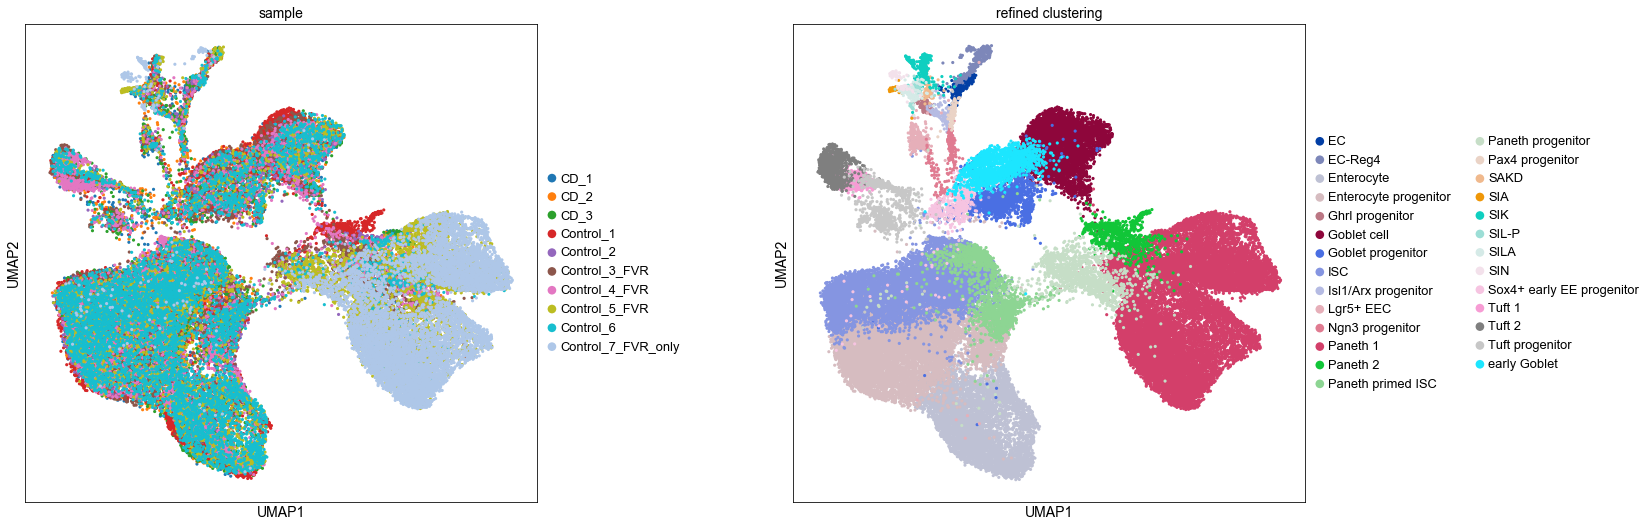

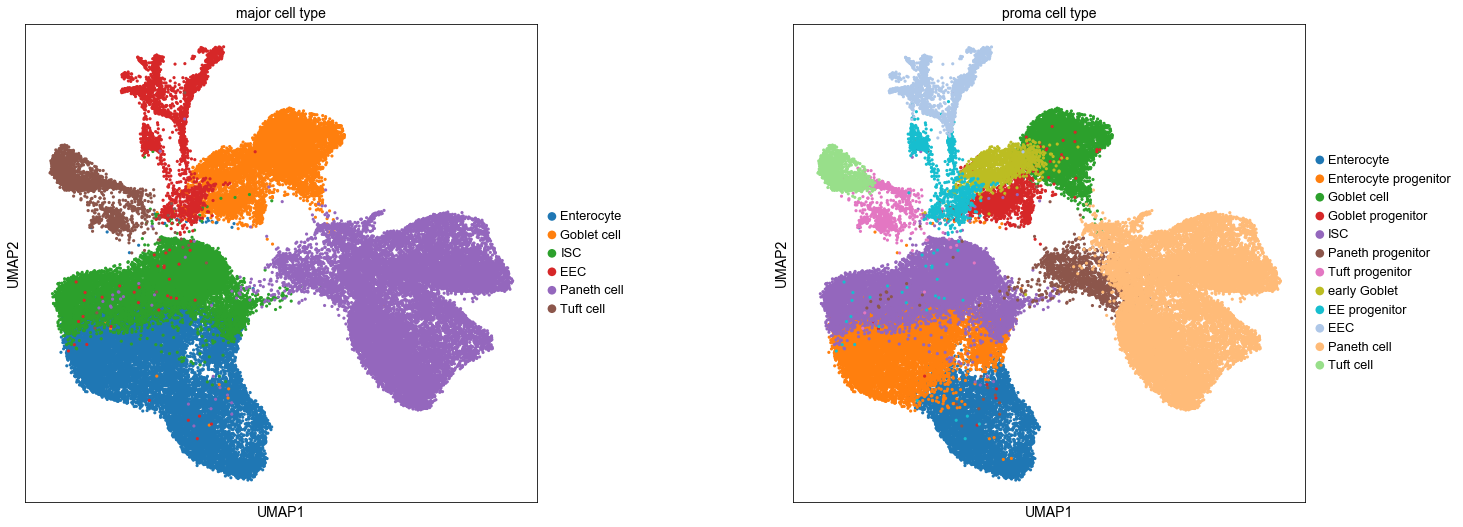

In [106]:
rcParams['figure.figsize']=(8,8)
sc.pl.umap(adata_ctrl, color=['sample', 'refined_clustering'], size=40)
sc.pl.umap(adata_ctrl, color=['major_cell_type', 'proma_cell_type'], size=40)

Save data to file.

In [108]:
adata_ctrl.write('./../data/gut_AB_AL_log_cor_control_anno.h5ad')
